# Introduction and Set Up

Facial recognition is rapidly becoming a key topic in the field of machine learning. Facial recognition systems can be used to identify people in photos, video, or in real-time. Certain agencies are using this technology to identify people from photographs and many technological tools are using this technology to add security to user devices. 

The first step in building something like this is to identify the facial keypoints from a image. Facial Keypoints are the areas of the nose, eyes, and mouth, that can be classified by a series of points, with coordinates (x, y), for that face. Every image of a human face has some amount of facial keypoints. With facial keypoints, we can obtain a plethora of information, including the identity of the person in the photo, their emotions, and even whether they are real or not. 

This will allow future data scientists to do things such as develop new face filters, for a service like Snapchat, and research user emotions and poses. It will also medical experts to detect dysmorphic facial signs for medical diagnosis. Ultimately though, detecting facial keypoints is a difficult problem because facial features vary greatly from one image of an individual to another. There can be a large amount of variance between the poses, sizes, angles and positions of an image.

For our project, we will tackle some of the challenges head-on. Using 7049 images from Kaggle’s Facial Keypoints Detection challenge, we have developed a framework for identifying these key points from specific photographs.

First, we'll import the necessary Python packages used later in the document.

In [ ]:
import json
import os
import zipfile
from time import sleep
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, \
    Flatten, Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, clone_model
from keras.preprocessing.image import ImageDataGenerator
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii

%matplotlib inline

  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp36-none-any.whl size=3063 sha256=e93600170270b277cd2fe4116d304fa246a1ec4961642673fd6d103e93f76b9a
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Next, the raw competition data is downloaded into the `/content/competitions` directory.

In [ ]:
# raw api token
api_token = {"username":"derektopper",
             "key":"e2dc6654f1c2c5062f7349ca6c83ec5e"}

# create dir and write to readable json
if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

# Download raw kaggle data
!kaggle config set -n path -v /content
!kaggle competitions download -c facial-keypoints-detection


# unzip training and test data
Root_Dir = '/content/competitions/facial-keypoints-detection'
for file in os.listdir(Root_Dir):
  if file.endswith('.zip'):
    zip_ref = zipfile.ZipFile(os.path.join(Root_Dir, file), 'r')
    zip_ref.extractall(Root_Dir)
    zip_ref.close()
  
# read in data
train_data = pd.read_csv(os.path.join(Root_Dir, 'training.csv'))  
test_data = pd.read_csv(os.path.join(Root_Dir, 'test.csv'))
lookid_data = pd.read_csv(os.path.join(Root_Dir, 'IdLookupTable.csv'))



- path is now set to: /content
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 77.8MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 56.2MB/s]
 67% 40.0M/60.1M [00:00<00:00, 141MB/s]
100% 60.1M/60.1M [00:00<00:00, 200MB/s]
 75% 12.0M/16.0M [00:00<00:00, 33.7MB/s]
100% 16.0M/16.0M [00:00<00:00, 40.4MB/s]



# Exploratory Data Analysis (EDA)



Let's begin by taking a look at our training data. We'll print out the first 3 rows, columnwise for readability. We can see that there are xy coordinates for 15 different keypoints, alongside the actual image data stored as a vector in the `Image` column.

As we mentioned earlier, there are 15 different keypoints that we'll be identifying in this project. Those are:



*   Left Eye (Center, Inner Corner, Outer Corner)
*   Right Eye (Center, Inner Corner, Outer Corner)
*   Left Eyebrow (Inner Corner, Outer Corner)
*   Right Eyebrow (Inner Corner, Outer Corner)
*   Nose (Tip)
*   Mouth (Left Corner, Right Corner)
*   Top Lip (Center)
*   Bottom Lip (Center)

These are among the most important things that a computer vision system will look for when identifying people from images.


In [ ]:
train_data.head(3).T

0  ...                                                  2
left_eye_center_x                                                    66.0336  ...                                            65.0571
left_eye_center_y                                                    39.0023  ...                                            34.9096
right_eye_center_x                                                    30.227  ...                                            30.9038
right_eye_center_y                                                   36.4217  ...                                            34.9096
left_eye_inner_corner_x                                              59.5821  ...                                             59.412
left_eye_inner_corner_y                                              39.6474  ...                                             36.321
left_eye_outer_corner_x                                              73.1303  ...                                            70.9844
left_eye_outer_corner_y                                                39.97  ...                                             36.321
right_eye_inner_corner_x                                             36.3566  ...                                            37.6781
right_eye_inner_corner_y                                             37.3894  ...                                             36.321
right_eye_outer_corner_x                                             23.4529  ...                                            24.9764
right_eye_outer_corner_y                                             37.3894  ...                                            36.6032
left_eyebrow_inner_end_x                                             56.9533  ...                                            55.7425
left_eyebrow_inner_end_y                                             29.0336  ...                                            27.5709
left_eyebrow_outer_end_x                                             80.2271  ...                                            78.8874
left_eyebrow_outer_end_y                                             32.2281  ...                                            32.6516
right_eyebrow_inner_end_x                                            40.2276  ...                                            42.1939
right_eyebrow_inner_end_y                                            29.0023  ...                                            28.1355
right_eyebrow_outer_end_x                                            16.3564  ...                                            16.7912
right_eyebrow_outer_end_y                                            29.6475  ...                                            32.0871
nose_tip_x                                                           44.4206  ...                                            47.5573
nose_tip_y                                                           57.0668  ...                                            53.5389
mouth_left_corner_x                                                  61.1953  ...                                            60.8229
mouth_left_corner_y                                                  79.9702  ...                                            73.0143
mouth_right_corner_x                                                 28.6145  ...                                            33.7263
mouth_right_corner_y                                                  77.389  ...                                             72.732
mouth_center_top_lip_x                                               43.3126  ...                                            47.2749
mouth_center_top_lip_y                                               72.9355  ...                                            70.1918
mouth_center_bottom_lip_x                                            43.1307  ...                                            47.2749
mouth_center_bottom_lip_y                                            84.4858  ...    

To check the integrity of the data, let's see if there are any null values. Using the `Seaborn` package, we plot a simple heatmap. In the visual below, we can see that all samples have image data, there are a small set of samples with only a couple keypoints missing, and a large percentage of samples where it appears keypoints were stripped out. For these stripped-samples, the 4 keypoints available are:
- centers of eyes (2)
- tip of nose
- center of bottom lip

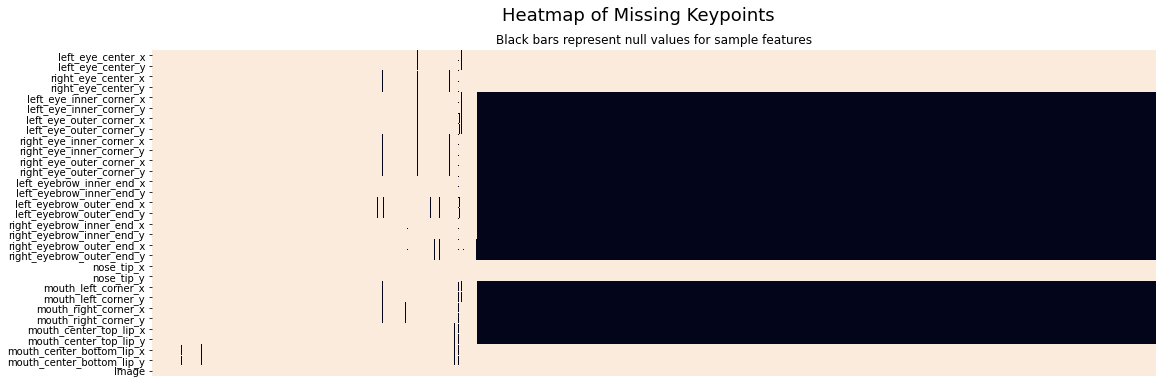

In [ ]:
# heatmap of null values
plt.rcParams["figure.figsize"]=(18, 6)
sns.heatmap(~train_data.isnull().T,
            xticklabels = False,
            cbar =False)
plt.suptitle('Heatmap of Missing Keypoints', size=18)
plt.title('Black bars represent null values for sample features')
plt.show()

We'll split our training data into two sets:

1.   "Complete" training set, containing only samples with no missing keypoints
2.   "Incomplete" training set, containing only samples with at least 1 missing keypoint



In [ ]:
# subset into samples will complete keypoints or not
incomplete_train_data = train_data[train_data.isnull().any(axis=1)]
complete_train_data = train_data[~train_data.isnull().any(axis=1)]

print(f"Samples with no missing keypoints: {len(complete_train_data)}")
print(f"Samples with missing keypoints: {len(incomplete_train_data)}")

Samples with no missing keypoints: 2140
Samples with missing keypoints: 4909


Next, let's split our features (image data) and labels (keypoints) into different arrays. We'll also go ahead and reshape our images into the appropriate 96x96 pixel image and normalize the 8-bit grayscale by dividing by 255. 

In [ ]:
# transform images and labels
def process_training_data(data):
    images = []
    keypoints = []
    for idx, sample in data.iterrows():
      # extract and reshape image
      image = np.reshape(np.array(sample['Image'].split(' '),
                                  dtype=int),
                         (96,96,1))
      images.append(image)
        # extract keypoints
      keypoints.append(sample.drop('Image'))
    # convert keypoints to array
    keypoints = np.array(keypoints, dtype = 'float')

    # normalize grayscale images and convert to array
    images = np.array(images)/255.
    return images, keypoints

# get complete training data
X_train, y_train = process_training_data(train_data)

# get complete training data
complete_X_train, complete_y_train = process_training_data(complete_train_data)

# get incomplete training data
incomplete_X_train, incomplete_y_train = process_training_data(incomplete_train_data)

Let's see if we have any duplicate values in our "Complete" training set:

In [ ]:
print("Size of complete X set: ")
print(complete_X_train.shape)
print("\nSize of unique complete X set: ")
print(np.unique(complete_X_train, axis=0).shape)
print("\nSize of complete y set: ")
print(complete_y_train.shape)
print("\nSize of unique complete X set: ")
print(np.unique(complete_y_train, axis=0).shape)

Size of complete X set: 
(2140, 96, 96, 1)

Size of unique complete X set: 
(2140, 96, 96, 1)

Size of complete y set: 
(2140, 30)

Size of unique complete X set: 
(2140, 30)


It looks like there are no duplicates. Let's take a look at some of our "complete" samples that contain all 15 keypoints:




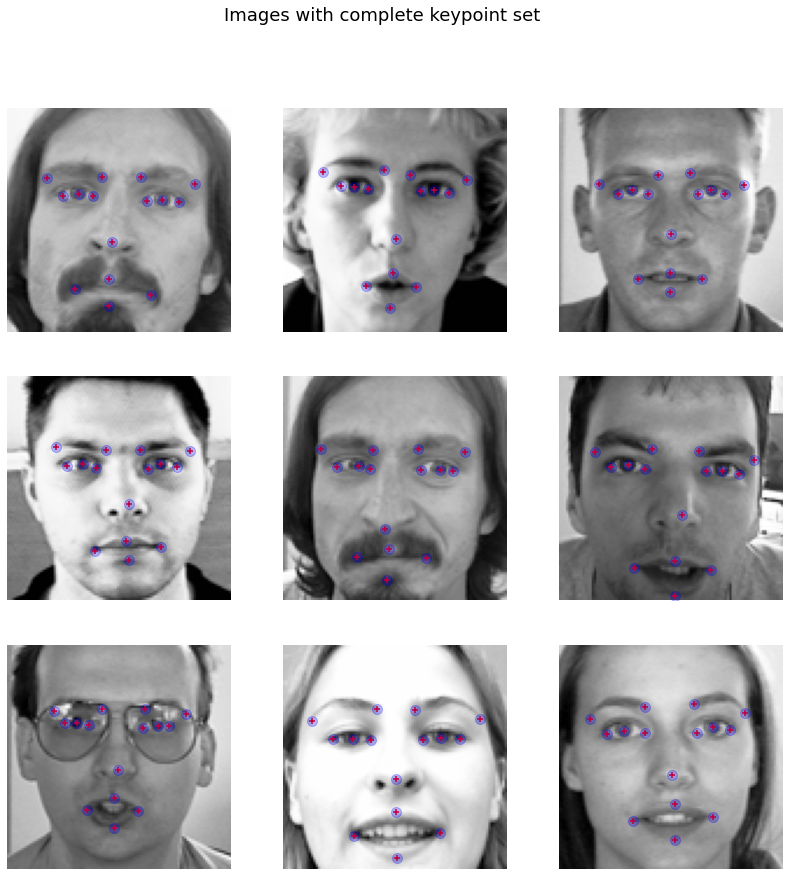

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.reshape(complete_X_train[i]*(-1), [96, 96]), cmap='Greys')
    ax.axis('off')
    x_coords = []
    y_coords = []
    for col in train_data.columns.to_list():
      if col.endswith('_x'):
        x_coords.append(train_data[col][i])
      if col.endswith('_y'):
        y_coords.append(train_data[col][i])
    ax.scatter(x_coords, y_coords, marker='+', c='red')
    ax.scatter(x_coords, y_coords, s=100, c='blue', alpha=0.25)
plt.suptitle('Images with complete keypoint set', size=18)
plt.show()


As you can see from the above images, many of the items in our training data set are very accurate. Even despite features such as glasses, and different facial expressions, we have a good bit of data to work from. Not all of our images are like the ones above, however.

In the images below, we can see that our dataset has plenty of images that play around with these issues. For example, in the images below, there are faces that are looking upwards, are turned to the side, and are displaying varied facial expressions, such as smiles and sadness.

Ultimately, however, the images below are also missing one or more of the keypoints that I mentioned earlier. This is generally because of the way that the faces are turned. Let's take a look at some of our "incomplete" samples that do not contain all 15 keypoints:


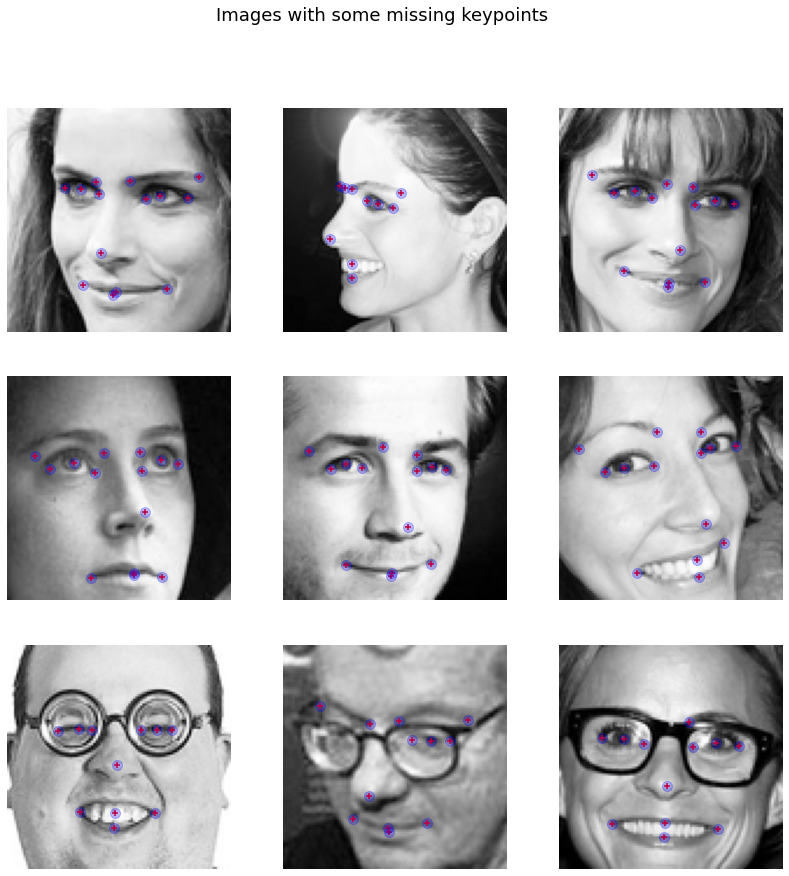

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.reshape(incomplete_X_train[i+17]*(-1), [96, 96]), cmap='Greys')
    ax.axis('off')
    x_coords = []
    y_coords = []
    for j, key in enumerate(incomplete_y_train[i+17]):
      if j%2 == 0:
        x_coords.append(key)
      else:
        y_coords.append(key)
    ax.scatter(x_coords, y_coords, marker='+', c='red')
    ax.scatter(x_coords, y_coords, s=100, c='blue', alpha=0.25)
plt.suptitle('Images with some missing keypoints', size=18)
plt.show()

As you can see from the above images, many of the items in our training data set are missing important keypoints. Even despite having most of the relavant keypoints, and despite each keypoint being mostly present in the image. This is something we will need to account for. Some images have keypoints blokced by things like hair or glasses. This is also something we will need to account for. Not all of our "incomplete" images are even as complete like the ones above, however.

In the images below, we can see that our dataset has plenty of images that have very few keypoints. For example, in the images below, there are faces that appear like they should have all the features but only have 4 key points. Some are also distorted in some way, such as their angle.

Ultimately, for whatever reason, we have images with only 4 keypoints. We will need to come up with a way to account for this type of data, in our solution.

Let's take a look at some of our "incomplete" samples that only contain 4 keypoints:


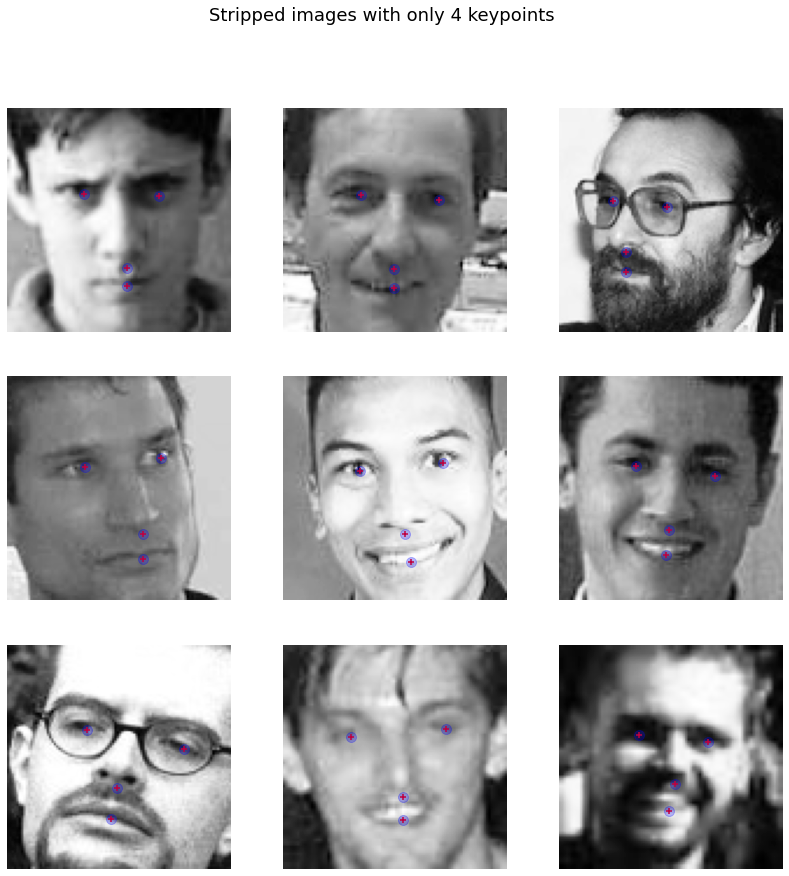

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.reshape(incomplete_X_train[i+150]*(-1), [96, 96]), cmap='Greys')
    ax.axis('off')
    x_coords = []
    y_coords = []
    for j, key in enumerate(incomplete_y_train[i+150]):
      if j%2 == 0:
        x_coords.append(key)
      else:
        y_coords.append(key)
    ax.scatter(x_coords, y_coords, marker='+', c='red')
    ax.scatter(x_coords, y_coords, s=100, c='blue', alpha=0.25)
plt.suptitle('Stripped images with only 4 keypoints', size=18)
plt.show()

Now that we have seen the quality of our dataset, we are going to need to fix the images, like the above. We need to have a strategy to handle the missing keypoint data. 

Clearly, there are problems with the above images that we will need to account for.

# Handling of Missing Keypoints



There are quite a few options and considerations when considering how to handle the missing keypoints. We need our solution to be automatic and scalable, so that we don't have to manually add keypoints everytime we add new data. 

One option would be to forward fill our training data. Forward filling is used to fill missing values in our dataframe. It will propagate the last valid observation forward. This is problematic for a number of reasons. As you will see when we plot this on images, it works for some of our data but does not work for all of our data.

In [ ]:
# forward fill training data
ffilled_train_data = train_data.fillna(method = 'ffill')

# subset to sample that were originally missing data
incomplete_ffilled_train_data = ffilled_train_data[train_data.isnull().any(axis=1)]

# process incomplete ffilled training data
incomplete_ffilled_X_train, incomplete_ffilled_y_train = process_training_data(
    incomplete_ffilled_train_data)

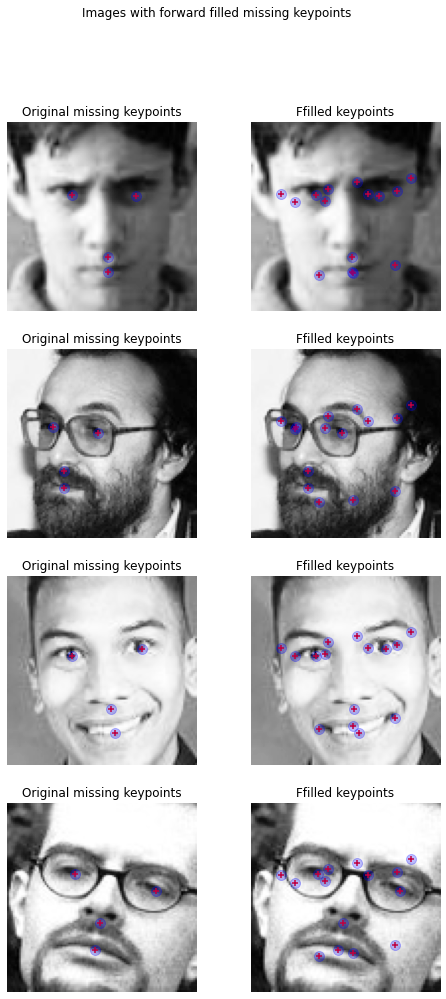

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(4, 2, figsize=(8, 16), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  if i%2 == 0:
    i_orig = i
    img = incomplete_X_train[i+150]
    keys = incomplete_y_train[i+150]
    ax.title.set_text('Original missing keypoints')
  else:
    img = incomplete_ffilled_X_train[i_orig+150]
    keys = incomplete_ffilled_y_train[i_orig+150]
    ax.title.set_text('Ffilled keypoints')
  it = iter(keys)
  xy_coords = [(x, y) for x, y in zip(it, it)]
  ax.imshow(np.reshape(img*(-1), [96, 96]), cmap='Greys')
  ax.axis('off')
  ax.scatter(*zip(*xy_coords), marker='+', c='red')
  ax.scatter(*zip(*xy_coords), s=100, c='blue', alpha=0.25)
plt.suptitle('Images with forward filled missing keypoints')
plt.show()

Looking at the images above, there are clear problems. While the first and third images appear to line up pretty well, the second and fourth images do not. For the first image, the right mouth corner and the left eye outer corner, appear to be slightly off, but the rest of the data appears to be good. For the second image, none of the keypoints are where they should be. For the third image, this approach appears to be a near perfect match. Finally, for the fourth image, the data is again very off. 

Ultimately, from this, we determined that this was not a truly viable result. The keypoints will not be accurate if we are simply pasting the points from the last full facial image onto every image missing data. Every image is different so forward filling is not appropriate for this problem. Thus, we explored a new solution.


# Data Augmentation

For now, we will move forward using only images that have all keypoints available. We will return to the images missing keypoints in later sections.


In order to make our model robust, we will augment our dataset with additional images. We use the `ImageDataGenerator` from `keras` to shift, shear, scale, and adjust brightness on some of the provided images. Then, we use a module that applies the same transformations to the keypoints, so that they map accurately onto the transformed images ([link to this module here](https://github.com/keras-team/keras-preprocessing/pull/132#issuecomment-537836519)). 

We did not write this module, though we stepped through each method to ensure that the code was sound. This module takes the transform parameters generated by `ImageDataGenerator`, then applies them as an affline transform to the keypoint coordinates. It also checks if the transformed keypoints are within the new image bounding box. This means that if the transform moves the points outside of the image area, that is detected so the sample can be skipped.

In [ ]:
class ImageDataGeneratorLandmarks(ImageDataGenerator):
    """
    Generator to transform the landmarks in the same way as the augmented (transformed) images.

    This generator assumes all landmarks belong to images of the same size (width x height).
    If you have annotated landmarks in images of different size but resize them later on,
    for example using the target_size parameter of the ImageDataGenerator, then you must
    first normalize your landmark coordinates to the target image size.
    You can do so through the helper function normalize_landmarks in this module.

    After transforming (rotating, scaling, shifting, ...) landmarks can end up outside visible part of the image.
    This generator automatically calculates if the landmark is still visible. If not, the landmark-present
    indicator is automatically set to 0.0.

    Landmarks must be placed in the 'x' of the dataset and be encoded as follows:
        Shape:
            (batch_index, landmark, 3)

        Where each landmark consists of 3 elements:
            - X coordinate
            - Y coordinate
            - Present indicator (0.0 if not present, 1.0 if present)

        Example:
            [
                [   [landmark_1_x, landmark_1_y, landmark_1_present],
                    [landmark_2_x, landmark_2_y, landmark_2_present] ],
                [   [landmark_1_x, landmark_1_y, landmark_1_present],
                    [landmark_2_x, landmark_2_y, landmark_2_present] ]
            ]

    Code based on:
    https://github.com/keras-team/keras-preprocessing/pull/132/commits
    """

    def __init__(self, width, height,
                 featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                 samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-6, rotation_range=0,
                 width_shift_range=0., height_shift_range=0., brightness_range=None, shear_range=0., zoom_range=0.,
                 channel_shift_range=0., fill_mode='nearest', cval=0., horizontal_flip=False, vertical_flip=False,
                 rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None):
        """
        :type width: Integer. Width of the images.
        :type height: Integer. Height of the images.
        """
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization,
                         samplewise_std_normalization, zca_whitening, zca_epsilon, rotation_range, width_shift_range,
                         height_shift_range, brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode,
                         cval, horizontal_flip, vertical_flip, rescale, preprocessing_function, data_format,
                         validation_split, dtype)
        self.image_width = width
        self.image_height = height

    def flow_landmarks(self, landmarks, batch_size=32, shuffle=True, seed=None, subset=None):
        # Convert landmarks to 4-rank to remain compatible with downstream Keras code
        s = landmarks.shape
        x = landmarks.reshape((s[0], s[1], s[2], 1))
        return super().flow(x, None, batch_size, shuffle, None, seed, None, '', 'png', subset)

    def apply_transform(self, x, transform_parameters):
        # Fix translation!
        # It is miscalculated because is it based the tensor shape is taken as image width/height.
        wrong_img_shape = x.shape
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        tx_factor = self.image_height / wrong_img_shape[img_row_axis]
        ty_factor = self.image_width / wrong_img_shape[img_col_axis]
        transform_parameters['tx'] = transform_parameters['tx'] * tx_factor
        transform_parameters['ty'] = transform_parameters['ty'] * ty_factor

        # Landmarks are of a single sample. So a 3-rank array.

        # Convert to 2-rank
        landmarks = x.reshape((x.shape[0], x.shape[1]))

        # Extract only the X/Y for transformations and transform
        landmarks_xy = landmarks[:, 0:2]
        landmarks_xy_transformed = _transform_landmarks(
            self.image_width,
            self.image_height,
            landmarks_xy,
            transform_parameters
        )

        # Determine if the landmarks are still inside the image
        landmarks_visibilities = (landmarks_xy_transformed[:, 0] >= 0) & \
                                 (landmarks_xy_transformed[:, 0] < self.image_width) & \
                                 (landmarks_xy_transformed[:, 1] >= 0) & \
                                 (landmarks_xy_transformed[:, 1] < self.image_height)

        # Pack result back in original landmarks (they are a copy anyway)
        landmarks[:, 0:2] = landmarks_xy_transformed
        landmarks[:, 2] = landmarks_visibilities

        # Restore the 3-rank array
        return landmarks.reshape(x.shape)


def derank_landmarks_output(landmarks_output):
    """
    Removes the last dimension from the landmarks output by the ImageDataGeneratorLandmarks.

    :param landmarks_output:
    :return:
    """
    return landmarks_output.reshape(landmarks_output.shape[:-1])


def normalize_landmarks(landmarks, image_widths, image_heights, target_width=1.0, target_height=1.0):
    """
    Normalize image landmarks between 0.0 and 1.0 or between 0.0 and target image width/height.

    Input:
        Numpy array of landmarks of shape (n, 2+) where:
            - n is the number of landmarks
            - 2+ are the landmark x, landmark y and optionally other data that is not touched.

    :param landmarks: Numpy array containing landmarks
    :param image_widths: Numpy array of widths of images in same order as the landmarks
    :param image_heights: Numpy array of heights of images in same order as the landmarks
    :param target_width: Float. Optional. Width of target image, default 1.0
    :param target_height: Float. Optional. Height of target image, default 1.0
    :return: Copy of landmarks array with the x and y normalized.
    """
    widths_correction = target_width / image_widths
    heights_correction = target_height / image_heights

    landmarks_normalized = landmarks.copy()
    for i in range(landmarks.shape[1]):
        landmarks_normalized[:, i, 0] = landmarks[:, i, 0] * widths_correction
        landmarks_normalized[:, i, 1] = landmarks[:, i, 1] * heights_correction

    return landmarks_normalized


def _transform_landmarks(width, height, landmarks, transform_parameters):
    """Applies a transformation to an tensor of landmarks on an image according to given parameters.
    # Arguments
        x: 3D tensor, single image. Required only to analyze image dimensions.
        landmarks: 3D tensor, containing all the 2D points to be transformed.
        transform_parameters: Dictionary with string - parameter pairs
            describing the transformation.
            Currently, the following parameters
            from the dictionary are used:
            - `'theta'`: Float. Rotation angle in degrees.
            - `'tx'`: Float. Shift in the x direction.
            - `'ty'`: Float. Shift in the y direction.
            - `'shear'`: Float. Shear angle in degrees.
            - `'zx'`: Float. Zoom in the x direction.
            - `'zy'`: Float. Zoom in the y direction.
            - `'flip_horizontal'`: Boolean. Horizontal flip.
            - `'flip_vertical'`: Boolean. Vertical flip.
    # Returns
        A transformed version of the landmarks.
    """
    landmarks = _affine_transform_points(landmarks, height, width,
                                         transform_parameters.get('theta', 0),
                                         transform_parameters.get('tx', 0),
                                         transform_parameters.get('ty', 0),
                                         transform_parameters.get('shear', 0),
                                         transform_parameters.get('zx', 1),
                                         transform_parameters.get('zy', 1)
                                         )

    landmarks = _flip_points(
        landmarks,
        height,
        width,
        flip_horizontal=transform_parameters.get('flip_horizontal', 0),
        flip_vertical=transform_parameters.get('flip_vertical', 0)
    )

    return landmarks


def _affine_transform_points(points, height, width, theta=0, tx=0, ty=0, shear=0, zx=1, zy=1):
    """Applies an affine transformation of the points specified
     by the parameters given.
    # Arguments
        points: 3D tensor, containing all the 2D points to be transformed.
        height: Height of the image the points are part of
        width: Width of the image the points are part of
        theta: Rotation angle in degrees.
        tx: Width shift.
        ty: Height shift.
        shear: Shear angle in degrees.
        zx: Zoom in x direction.
        zy: Zoom in y direction
    # Returns
        The transformed version of the points.
    """
    transform_matrix = _get_affine_transform_matrix(
        height, width,
        theta, tx, ty, shear, zx, zy)

    if transform_matrix is not None:
        homogeneous_points = np.transpose(points)
        homogeneous_points = np.insert(homogeneous_points[[1, 0]], 2, 1, axis=0)
        inverse = np.linalg.inv(transform_matrix)
        homogeneous_points = np.dot(inverse, homogeneous_points)
        points = homogeneous_points[[1, 0]]
        points = np.transpose(points)

    return points


def _flip_points(points, height, width, flip_horizontal=False, flip_vertical=False):
    """Flips the coordinates of points in a frame with dimensions height and width
    horizontally and/or vertically.
    # Arguments
        x: Point tensor. Must be 3D.
        height: Height of the frame.
        width: Width of the frame.
        flip_horizontal: Boolean if coordinates shall be flipped horizontally.
        flip_vertical: Boolean if coordinates shall be flipped vertically.
    # Returns
        Flipped Numpy point tensor.
    """
    if flip_horizontal or flip_vertical:
        points = points * np.array(
            [1 - 2 * flip_horizontal, 1 - 2 * flip_vertical]) + np.array(
            [width * flip_horizontal, height * flip_vertical])
    return points


def _get_affine_transform_matrix(height, width, theta=0, tx=0, ty=0, shear=0, zx=1, zy=1):
    """Compute the affine transformation specified by the parameters given.

    # Arguments
        height: Height of the image to transform
        width: Width of the image to transform
        theta: Rotation angle in degrees.
        tx: Width shift.
        ty: Height shift.
        shear: Shear angle in degrees.
        zx: Zoom in x direction.
        zy: Zoom in y direction

    # Returns
        The affine transformation matrix for the parameters
        or None if no transformation is needed.
    """

    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, tx],
                                 [0, 1, ty],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shift_matrix)

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)

    if transform_matrix is not None:
        transform_matrix = _transform_matrix_offset_center(
            transform_matrix, height, width)

    return transform_matrix


def _transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2
    o_y = float(y) / 2
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

In order to use the method above, we transform our keypoint coordinates into a array of xy keypoint pairs with an indicator of whether the keypoints are within the image bounding box. Since this is pre-transformation, all keypoints are within the image, so they are all set to 1.

In [ ]:
# function that reshapes keypoint
def reshape_keypoints(m):
  """
  Reshapes keypoints and adds indicator that keypoint exists (1)

  m: array of keypoints in shape [x1 y1 x2 y2 x3 y3 ...]
  return: array of coordinate pairs [[x1 y1 1] [x2 y2 1] ...]
  """
  it = iter(m)
  return [(x, y, 1) for x, y in zip(it, it)]

# function that unpacks keypoints
def unpack_keypoints(m):
  """
  Reshapes keypoints and adds indicator that keypoint exists (1)

  m: array of coordinate pairs [[x1 y1 1] [x2 y2 1] ...]
  return: array of keypoints in shape [x1 y1 x2 y2 x3 y3 ...]
  """
  unpacked = []
  for i in m:
    unpacked.append(i[0])
    unpacked.append(i[1])
  return np.array(unpacked)

# reshape keypoints
xy_keypoints = np.apply_along_axis(reshape_keypoints, 1, complete_y_train)

print("Example of keypoints before being reshaped:")
print("[x1 y1 x2 y2 x3 y3 ...]")
print(complete_y_train[0])
print("\nExample of keypoints after being reshaped:")
print("[[x1 y1 1] [x2 y2 1] [x3 y3 1] ...]")
print(xy_keypoints[0])
print("\nExample of keypoints after being unpacked:")
print("[x1 y1 x2 y2 x3 y3 ...]")
print(unpack_keypoints(xy_keypoints[0]))

Example of keypoints before being reshaped:
[x1 y1 x2 y2 x3 y3 ...]
[66.03356391 39.00227368 30.22700752 36.4216782  59.58207519 39.64742256
 73.13034586 39.96999699 36.35657143 37.3894015  23.45287218 37.3894015
 56.95326316 29.03364812 80.22712782 32.22813835 40.22760902 29.0023218
 16.35637895 29.64747068 44.42057143 57.06680301 61.19530827 79.97016541
 28.61449624 77.38899248 43.3126015  72.93545865 43.13070677 84.48577444]

Example of keypoints after being reshaped:
[[x1 y1 1] [x2 y2 1] [x3 y3 1] ...]
[[66.03356391 39.00227368  1.        ]
 [30.22700752 36.4216782   1.        ]
 [59.58207519 39.64742256  1.        ]
 [73.13034586 39.96999699  1.        ]
 [36.35657143 37.3894015   1.        ]
 [23.45287218 37.3894015   1.        ]
 [56.95326316 29.03364812  1.        ]
 [80.22712782 32.22813835  1.        ]
 [40.22760902 29.0023218   1.        ]
 [16.35637895 29.64747068  1.        ]
 [44.42057143 57.06680301  1.        ]
 [61.19530827 79.97016541  1.        ]
 [28.61449624 77.388

We then defined our transformation arguments as ranges and initialize generators for the images and keypoints with the same seed. The generators will apply transformations from the provided ranges randomly, and the seed will ensure that the keypoints and images are transformed the same way.

In [ ]:
# define transformation arguments
data_gen_args = dict(
    zoom_range=[0.8, 1.2],
    shear_range=5,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
)

# initialize generators
image_datagen = ImageDataGenerator(**data_gen_args)
landmark_datagen = ImageDataGeneratorLandmarks(width=96,
                                               height=96,
                                               **data_gen_args)

# set seed so transformations are the same for keypoints and images
seed = 123

# Combine generators 
train_generator = zip(image_datagen.flow(x=complete_X_train, seed=seed),
                      landmark_datagen.flow_landmarks(xy_keypoints, seed=seed))

Let's test out our workflow. We plot 9 images with random transformations below, and are able to confirm that the keypoints were appropriately mapped.

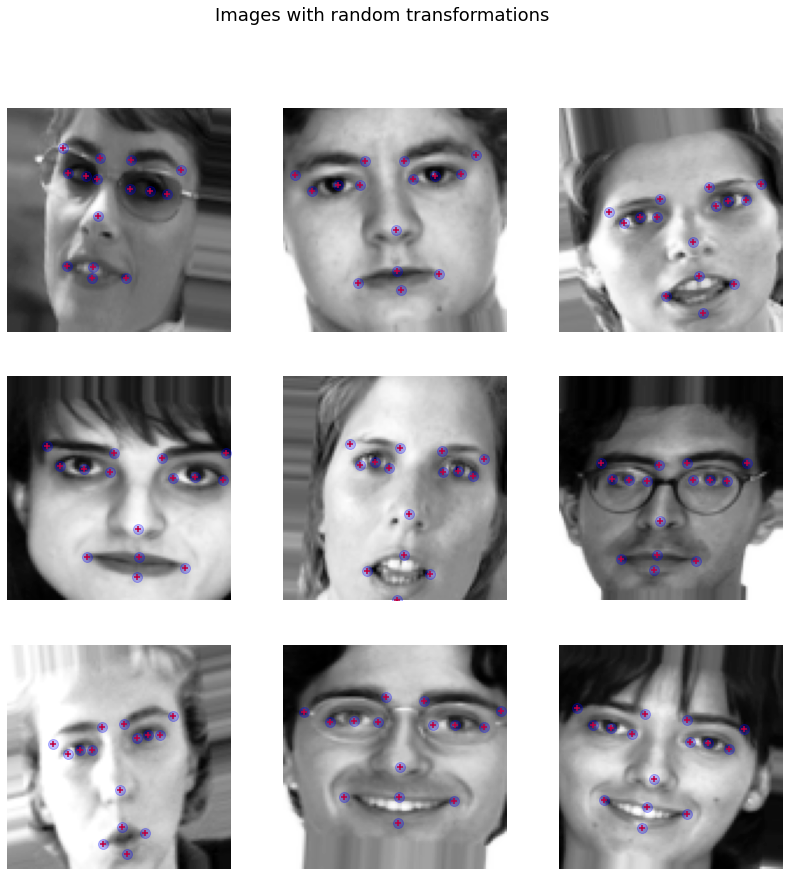

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  for img, landmarks in train_generator:
    # skip if landmarks are outside of boundary
    if np.any(landmarks[0,:,2] == 0):
      continue
    ax.imshow(img[0,:,:,0].reshape(96,96)*(-1), cmap='Greys')
    ax.scatter(landmarks[0,:,0], landmarks[0,:,1], marker='+', c='red')
    ax.scatter(landmarks[0,:,0], landmarks[0,:,1], s=100, c='blue', alpha=0.25)
    ax.axis('off')
    break
plt.suptitle('Images with random transformations', size=18)
plt.show()

Now that we have confirmed the method works appropriately, we will generate a large set of transformed images to augment our data with.

In [ ]:
# define function to generate images and keypoints
def augment_data(X, y, size):
  i = 0
  augmented_X_train = np.copy(X)
  augmented_y_train = np.copy(y)
  # generate batches of images and keypoints
  for imgs, landmarks in train_generator:
    # iterate over keypoints in batch
    for ind, landmark in enumerate(landmarks):
      # skip where any keypoint is outside boundary
      if np.any(landmark[:, 2]==0):
        continue
      # append image
      augmented_X_train = np.append(augmented_X_train,
                                    np.expand_dims(imgs[ind], axis=0),
                                    axis=0)
      augmented_y_train = np.append(augmented_y_train,
                                    unpack_keypoints(landmark).T,
                                    axis=0)
      i += 1
      if i == size:
        return augmented_X_train, augmented_y_train

augmented_X_train, augmented_y_train = augment_data(complete_X_train,
                                                    complete_y_train,
                                                    4000)

# Training a CNN Model

For the model portion to actually predict new keypoints, we are using a Convolutional Neural Network, also known as a CNN. A CNN is a type of neural network that uses Convolutional layers, a.k.a. Conv layers, which are based on the mathematical operation of convolution. A Conv layer works by effectively overlaying a filter on top of an image at some location, then preforming element-wise multiplication between the values in the filter and their corresponding values in the image. It then sums the element-wise products and outputs the value as a single pixel, before repeating this for every pixel. This is useful to help better denote the edges of images. 

Before creating our final complex model, we will first take a look at how a simple model behaves. Below we explore a model with only 5 layers:

In [ ]:
#Basic Model
model = Sequential([Flatten(input_shape=(96,96)),
                    Dense(128, activation="relu"),
                    Dropout(0.1),
                    Dense(64, activation="relu"),
                    Dense(30)])


This is a summary of how our base model works. We see that the `Dense` layer adds over one million trainable parameters.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
Total params: 1,189,982
Trainable params: 1,189,982
Non-trainable params: 0
_________________________________________________________________


The `keras2ascii` module lets us create a visualization of our base model.



In [ ]:
keras2ascii(model)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96   96
             Flatten   ||||| -------------------         0     0.0%
                       #####        9216
               Dense   XXXXX -------------------   1179776    99.1%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      8256     0.7%
                relu   #####          64
               Dense   XXXXX -------------------      1950     0.2%
                       #####          30


### Model

Many Keras models are built using the Sequential class, which represents a linear stack of layers. We will be progressively adding layers to our sequence.

Firstly, we start by adding a conv layer, as described earlier. The first convolution layer has an input_shape of 96 x 96, which is our image shape. It has 32 filters and a filter size of 3x3, meaning that the convolution approach from earlier will use a 3x3 grid. Finally, the padding level of 'same' means that our data will try to pad a single layer evenly on the left and right, to make the convolution work correctly.
 
Next, we apply a leaky ReLU, which an activation function that is added to layers in neural networks to add nonlinearity, which is important to handle modern complex and nonlinear datasets. In it, each neuron computes a dot product and adds a bias value before the value is output to the neurons in the subsequent layer.

Then we apply batch normalization, which applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. We then run each of those things again to maximize the efficiency of each piece.

Finally, before moving on to the number of filters in a new conv layer, we add in a max pooling layer to tie it all together. A max pooling layer is a type of operation that reduces the dimensionality of each image by reducing the number of pixels in the output from the previous convolutional layer. THis helps to reduce our computational load and reduce overfitting the data.

We then do this for a variety of different filter inputs, before implementing a flatten layer. Flatten is used to flatten the input, which is how we pass the data into the dense layers we'll need. We then use a dense layer, which is a fully connected layer where every neuron is connected to every neuron in the next layer. We also use a ReLU activation function, similar to the Leaky ReLU described above.

Next, we use a dropout level of 0.5 to cut down on excess association among features by dropping the weights (edges) at a probability. 

Finally, we take this and apply to a dense layer of 30 to produce our 30 keypoint estimations. We also use an adam optimizer, which is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

All of this comprises what became our CNN prediction model.





In [ ]:
model = Sequential()


model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30))

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae', 'acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)       

This is a visualization of our final model.

In [ ]:
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96   96    1
              Conv2D    \|/  -------------------       288     0.0%
                       #####     96   96   32
           LeakyReLU   ????? -------------------         0     0.0%
                       #####     96   96   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     96   96   32
              Conv2D    \|/  -------------------      9216     0.1%
                       #####     96   96   32
           LeakyReLU   ????? -------------------         0     0.0%
                       #####     96   96   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     96   96   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     48   48   32
              Conv2D    \|/  -------------------     18432     0.3%
              

Let's compare the performance of this CNN design using 3 different sets of data to train.

1.   Full data set including missing keypoints
2.   "Complete" data set with only images that have no missing keypoints
3.   "Augmented" data set consisting of the complete dataset and 4000 additional random transformations




In [ ]:
# create copies of untrained model
base_model = clone_model(model)
complete_model = clone_model(model)
augmented_model = clone_model(model)
pred_keypoints_model = clone_model(model)

# compile new models
base_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae', 'acc'])
complete_model.compile(optimizer='adam', 
                       loss='mean_squared_error',
                       metrics=['mae', 'acc'])
augmented_model.compile(optimizer='adam', 
                        loss='mean_squared_error',
                        metrics=['mae', 'acc'])
pred_keypoints_model.compile(optimizer='adam',
                             loss='mean_squared_error',
                             metrics=['mae', 'acc'])


We'll start by fitting the a model with the full data, including missing keypoints:

In [ ]:
history = base_model.fit(X_train,
                        y_train,
                        epochs = 100,
                        batch_size = 128,
                        validation_split=0.05)

Epoch 1/100
53/53 [==============================] - 8s 145ms/step - loss: nan - mae: nan - acc: 0.0013 - val_loss: nan - val_mae: nan - val_acc: 0.0000e+00
Epoch 2/100
53/53 [==============================] - 7s 126ms/step - loss: nan - mae: nan - acc: 0.0000e+00 - val_loss: nan - val_mae: nan - val_acc: 0.0000e+00
Epoch 3/100
53/53 [==============================] - 7s 126ms/step - loss: nan - mae: nan - acc: 1.4934e-04 - val_loss: nan - val_mae: nan - val_acc: 0.0000e+00
Epoch 4/100
53/53 [==============================] - 7s 127ms/step - loss: nan - mae: nan - acc: 7.4671e-04 - val_loss: nan - val_mae: nan - val_acc: 0.0000e+00
Epoch 5/100
53/53 [==============================] - 7s 127ms/step - loss: nan - mae: nan - acc: 0.0010 - val_loss: nan - val_mae: nan - val_acc: 0.0028
Epoch 6/100
53/53 [==============================] - 7s 128ms/step - loss: nan - mae: nan - acc: 1.4934e-04 - val_loss: nan - val_mae: nan - val_acc: 0.0000e+00
Epoch 7/100
53/53 [===========================

Next we'll fit a model to the provided images with no missing keypoints.

In [ ]:
complete_history = complete_model.fit(complete_X_train,
                    complete_y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_split=0.05)

Epoch 1/100
16/16 [==============================] - 4s 261ms/step - loss: 574.1867 - mae: 17.8584 - acc: 0.2002 - val_loss: 1264.4786 - val_mae: 32.7855 - val_acc: 0.4299
Epoch 2/100
16/16 [==============================] - 2s 147ms/step - loss: 131.9804 - mae: 9.1276 - acc: 0.2602 - val_loss: 422.0907 - val_mae: 18.7535 - val_acc: 0.4299
Epoch 3/100
16/16 [==============================] - 2s 145ms/step - loss: 93.7387 - mae: 7.7013 - acc: 0.3315 - val_loss: 387.0159 - val_mae: 17.9461 - val_acc: 0.4299
Epoch 4/100
16/16 [==============================] - 2s 146ms/step - loss: 75.6151 - mae: 6.9045 - acc: 0.3502 - val_loss: 297.9152 - val_mae: 15.7226 - val_acc: 0.4299
Epoch 5/100
16/16 [==============================] - 2s 146ms/step - loss: 67.6690 - mae: 6.5320 - acc: 0.3822 - val_loss: 191.3347 - val_mae: 12.4299 - val_acc: 0.4299
Epoch 6/100
16/16 [==============================] - 2s 146ms/step - loss: 58.9967 - mae: 6.0872 - acc: 0.3970 - val_loss: 181.3941 - val_mae: 12.0541 

Finally, we'll fit a model to our augmented dataset, containing images with no missing keypoints alongside the additional generated random transformations of those images:

In [ ]:
augmented_history = augmented_model.fit(augmented_X_train,
                    augmented_y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_split=0.05)

Epoch 1/100
46/46 [==============================] - 8s 176ms/step - loss: 315.6841 - mae: 12.6942 - acc: 0.2393 - val_loss: 454.9020 - val_mae: 18.6908 - val_acc: 0.5635
Epoch 2/100
46/46 [==============================] - 7s 148ms/step - loss: 81.4360 - mae: 7.1333 - acc: 0.3550 - val_loss: 504.8972 - val_mae: 20.0779 - val_acc: 0.4951
Epoch 3/100
46/46 [==============================] - 7s 147ms/step - loss: 60.7484 - mae: 6.1339 - acc: 0.4216 - val_loss: 286.4867 - val_mae: 14.8633 - val_acc: 0.5896
Epoch 4/100
46/46 [==============================] - 7s 147ms/step - loss: 50.8073 - mae: 5.5845 - acc: 0.4720 - val_loss: 179.2057 - val_mae: 11.4674 - val_acc: 0.6287
Epoch 5/100
46/46 [==============================] - 7s 148ms/step - loss: 44.8648 - mae: 5.2316 - acc: 0.4889 - val_loss: 46.7835 - val_mae: 5.7392 - val_acc: 0.7296
Epoch 6/100
46/46 [==============================] - 7s 148ms/step - loss: 42.3400 - mae: 5.0637 - acc: 0.5279 - val_loss: 45.7238 - val_mae: 5.7527 - val_

In training our model, I have kept a running tally of some of the early attempts of our base CNN. Below are the number of filters in each layer, and then the two dense layer inputs are in parentheses. For each of these attempts, I have shown the attempts that had higher accuracies and lower MAE values.

Pre Data Augmentation:
* 32-48-64-96-128-256 (256-30): Acc: 0.7224, Mae: 3.9815
* 32-64-128-256-512 (128-30): Acc: 0.6229, Mae: 5.9423
* 48-64-96-128-192-256 (128-30): Acc: 0.6186, MAE: 5.8305
* 32-64-96-128-256-512 (128-30): Acc: 0.6474, MAE: 5.4123
* 32-48-64-96-128-256 (128-30): Acc: 0.6519, MAE: 5.377
* 32-64-96-128-192-256 (256-30): Acc: 0.7119, MAE: 4.0641
* 32-64-96-128-256-512 (512-30): Acc: 0.7525, MAE: 3.2551
* 32-48-64-96-128-256-512 (512-30): Acc: 0.6007, MAE: 3.2089
* 64-128-256-512 (512-30): Acc: 0.6266, MAE: 5.1721
* 32-64-96-128-256-512-1024 (512-30): Acc: 0.6160, MAE: 3.3356
* 32-64-96-128-256-512-1024 (1024-30): Acc: 0.6056, MAE: 2.8476


Below is the visualizations of the MAE vs Epoch, Accuracy vs Epoch and Loss vs Epoch for each version of the model. Recall that we split off 5% of our samples as a validation set, retaining 95% of samples as the training set.

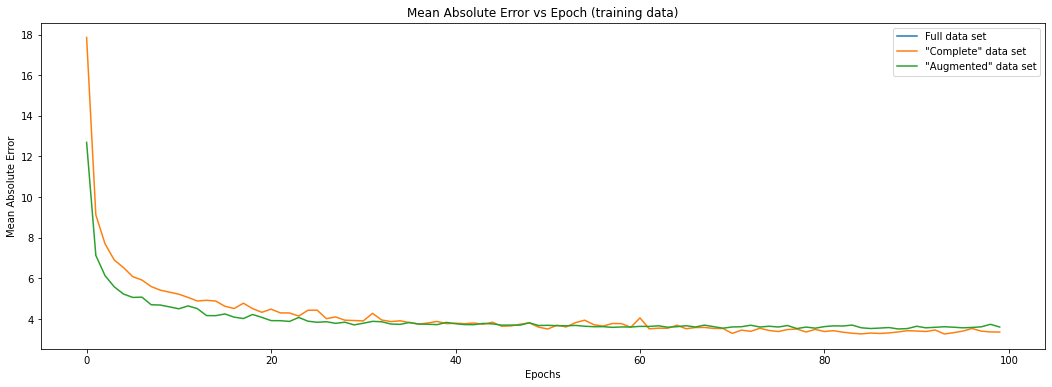

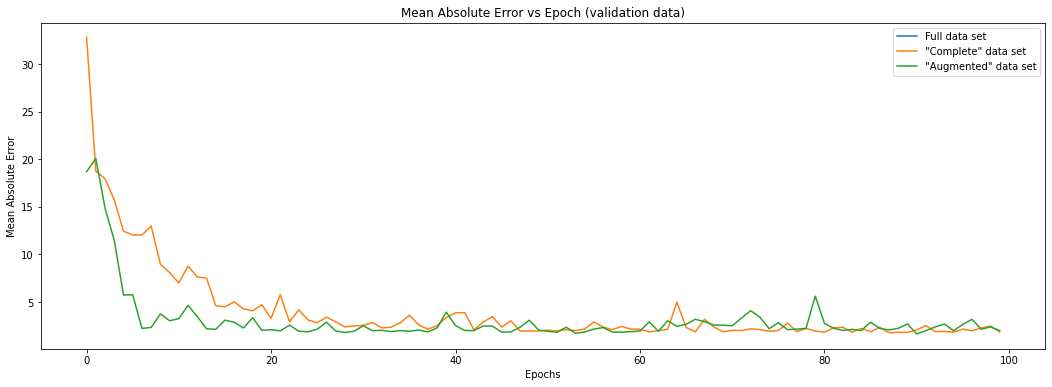

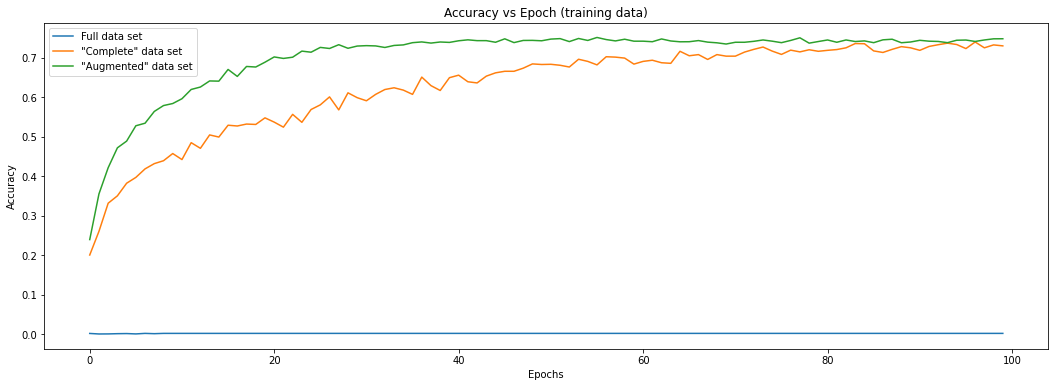

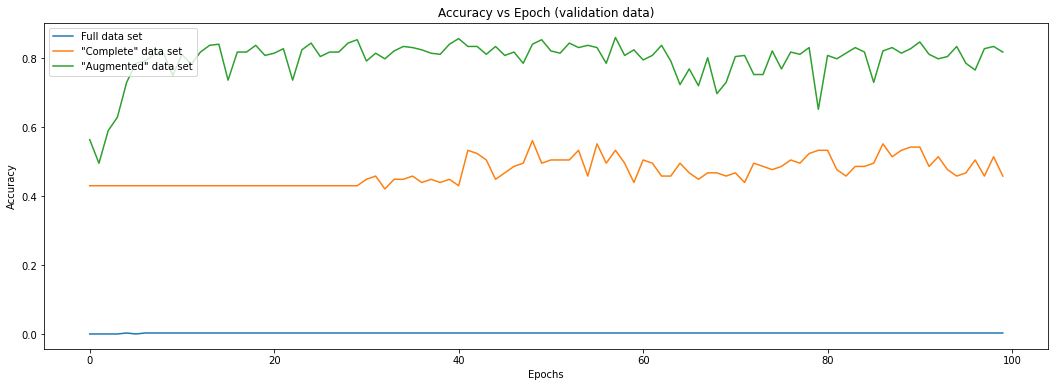

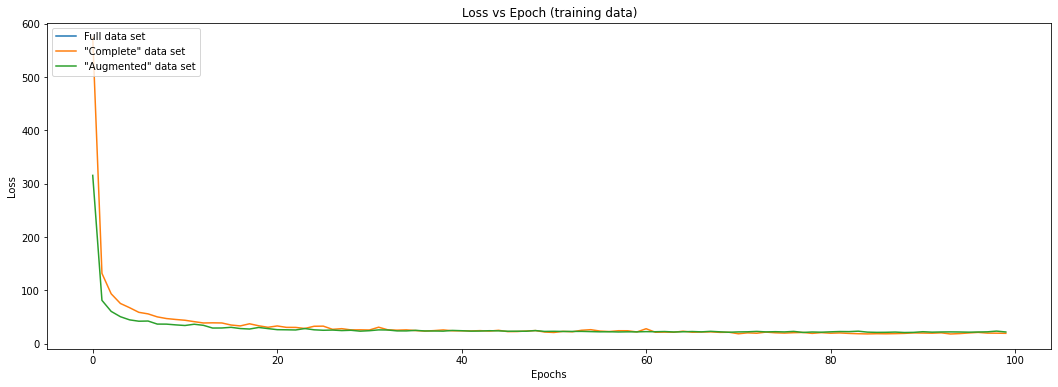

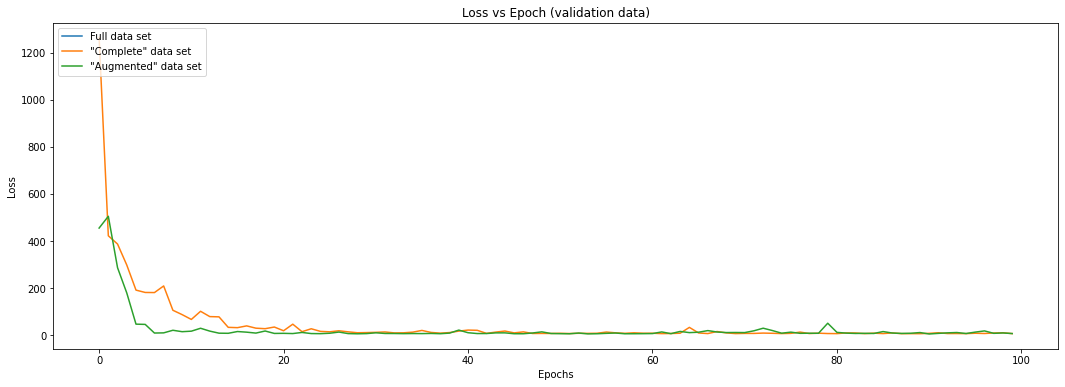

In [ ]:
# plot to show training MAE over time
plt.plot(history.history['mae'])
plt.plot(complete_history.history['mae'])
plt.plot(augmented_history.history['mae'])
plt.title('Mean Absolute Error vs Epoch (training data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper right')
plt.show()

# plot to show validation MAE over time
plt.plot(history.history['val_mae'])
plt.plot(complete_history.history['val_mae'])
plt.plot(augmented_history.history['val_mae'])
plt.title('Mean Absolute Error vs Epoch (validation data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper right')
plt.show()

# plot to show training accuracy over time
plt.plot(history.history['acc'])
plt.plot(complete_history.history['acc'])
plt.plot(augmented_history.history['acc'])
plt.title('Accuracy vs Epoch (training data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show validation accuracy over time
plt.plot(history.history['val_acc'])
plt.plot(complete_history.history['val_acc'])
plt.plot(augmented_history.history['val_acc'])
plt.title('Accuracy vs Epoch (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show training loss over time
plt.plot(history.history['loss'])
plt.plot(complete_history.history['loss'])
plt.plot(augmented_history.history['loss'])
plt.title('Loss vs Epoch (training data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show validation loss over time
plt.plot(history.history['val_loss'])
plt.plot(complete_history.history['val_loss'])
plt.plot(augmented_history.history['val_loss'])
plt.title('Loss vs Epoch (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Full data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

Above, it is clear that the Full data set model was unsuccessful. This is unfortunately due to the missing keypoint values. While the Complete model and Augmented model ended up with comparable results, the Augmented model appears to train in fewer epochs. At first glance, it appears that the Augmented model performs significantly better in the validation set, but this is likely due to the fact that the additional transformed images are modifications of other samples within the same set. This means that it is quite likely that in the 5% validation split, many of the samples are transformed versions of samples in the 95% training split. With all this in mind, let's move forward using our Augmented data set model.

# Evaluating Predictions

Let's take a look at some predictions from our models

In [ ]:
# generate predictions
base_pred = base_model.predict(incomplete_X_train)
complete_pred = complete_model.predict(incomplete_X_train)
augmented_pred = augmented_model.predict(incomplete_X_train)

# reshape predicted keypoints
base_pred_xy = np.apply_along_axis(reshape_keypoints, 1, base_pred)
complete_pred_xy = np.apply_along_axis(reshape_keypoints, 1, complete_pred)
augmented_pred_xy = np.apply_along_axis(reshape_keypoints, 1, augmented_pred)

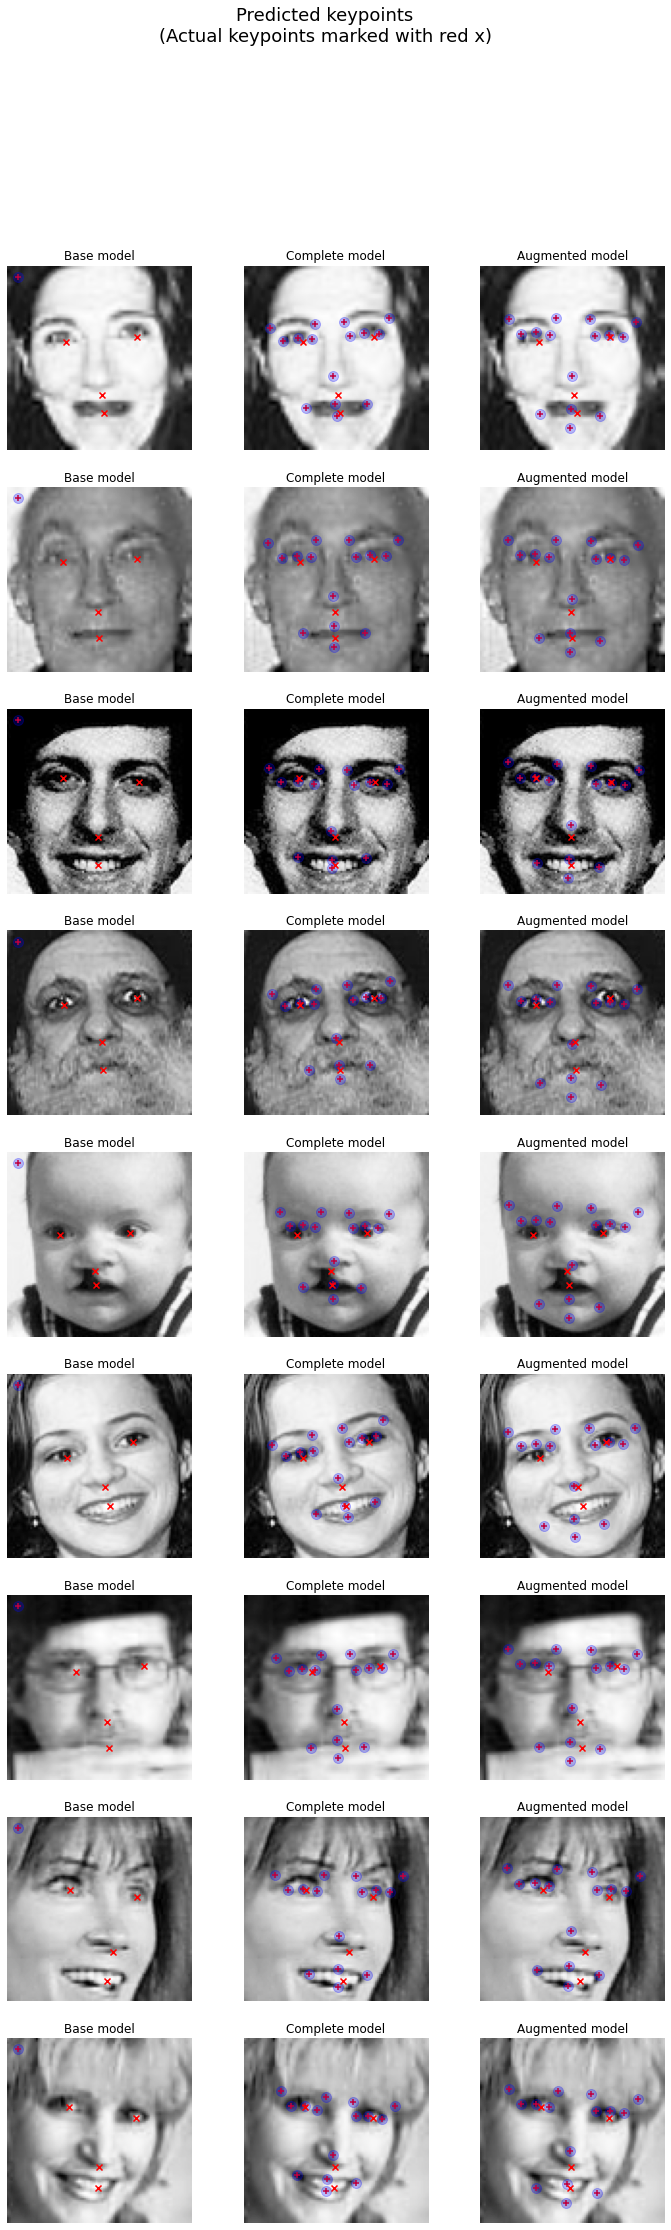

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(9, 3, figsize=(12, 36), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  if i in range(0, 27, 3):
    i_orig = i
    img = incomplete_X_train[i+200]
    true_keys = incomplete_y_train[i+200]
    keys = base_pred_xy[i+200]
    ax.title.set_text('Base model')
  elif i in range(1, 27, 3):
    keys = complete_pred_xy[i_orig+200]
    ax.title.set_text('Complete model')
  else:
    keys = augmented_pred_xy[i_orig+200]
    ax.title.set_text('Augmented model')
  ax.imshow(np.reshape(img*(-1), [96, 96]), cmap='Greys')
  ax.axis('off')
  ax.scatter(keys[:,0],
             keys[:,1],
             marker='+', c='red')
  ax.scatter(keys[:,0],
             keys[:,1],
             s=100, c='blue', alpha=0.25)
  it = iter(true_keys)
  xy_coords = [(x, y) for x, y in zip(it, it)]
  ax.scatter(*zip(*xy_coords), marker='x', c='red')
plt.suptitle('Predicted keypoints\n(Actual keypoints marked with red x)', size=18)
plt.show()

Visually, both the Augmented and Complete models have similar accuracy. They both appear quite accurate for some samples, while clearly inaccurate for others.  There does not appear to be enough evidence here to suggest that one model is substantially better than the other. We will continue with our Augmented model.

# Back to the Missing Keypoints

Now we'll use our predicted keypoints from the Augmented model to fill the missing keypoints in the "incomplete" set. We'll take our predicted keypoints and replace only the null values in the incomplete training keypoint set for the sample.

Original incomplete:
[66.93831111 43.42450963 31.09605926 39.52860444         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan 47.06925037 73.03333926         nan         nan
         nan         nan         nan         nan 45.90048    82.7730963 ]

Predicted:
[67.30463  37.391636 28.391094 35.149227 60.016235 37.92355  74.97786
 38.670376 35.737602 36.479565 20.496159 35.628536 57.382893 28.81059
 81.99249  30.89147  39.63285  27.945318 14.156646 27.464596 47.272964
 59.124737 61.679623 81.03168  29.935858 79.255875 46.11307  76.83959
 45.78864  86.83825 ]

Merged:
[66.93831111 43.42450963 31.09605926 39.52860444 60.01623535 37.92354965
 74.9778595  38.67037582 35.73760223 36.47956467 20.4961586  35.62853622
 57.38289261 28.81059074 81.99249268 30.89146996 39.63285065 27.94531822
 14.15664577 27.46459579 47.06925037 73.03333926 61.67962265 81.031677

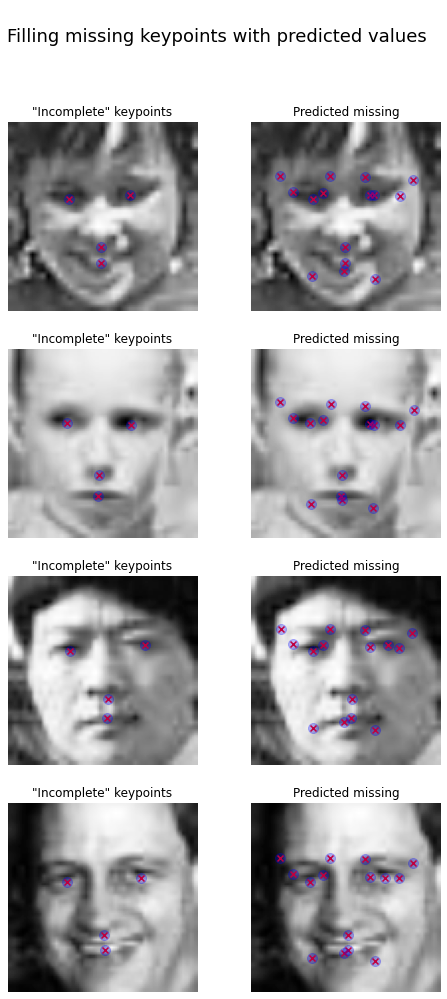

In [ ]:
def merge_keypoints(incomplete, predicted):
  return np.where(np.isnan(incomplete), predicted, incomplete)


print("Original incomplete:")
print(incomplete_y_train[-1])
print("\nPredicted:")
print(augmented_pred[-1])
print("\nMerged:")
print(np.where(
    np.isnan(incomplete_y_train[-1]),
    augmented_pred[-1],
    incomplete_y_train[-1]
))

# plot images with keypoints
fig, axs = plt.subplots(4, 2, figsize=(8, 16), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  if i in range(0, 16, 2):
    i_orig = i
    img = incomplete_X_train[i+310]
    keys = incomplete_y_train[i+310]
    ax.title.set_text('"Incomplete" keypoints')
  elif i in range(1, 16, 2):
    keys = merge_keypoints(incomplete_y_train[i_orig+310],
                           augmented_pred[i_orig+310])
    ax.title.set_text('Predicted missing')
  ax.imshow(np.reshape(img*(-1), [96, 96]), cmap='Greys')
  ax.axis('off')
  it = iter(keys)
  xy_coords = [(x, y) for x, y in zip(it, it)]
  ax.scatter(*zip(*xy_coords), marker='x', c='red')
  ax.scatter(*zip(*xy_coords), s=100, c='blue', alpha=0.25)
plt.suptitle('\nFilling missing keypoints with predicted values', size=18)
plt.show()




While the above method was not perfect, it does appear to perform much better than forward-filling the missing points. Let's take our Augmented data set, and append this set of predicted points.

In [ ]:
# merge missing points
pred_keypoints_y_train = np.where(
    np.isnan(incomplete_y_train),
    augmented_pred,
    incomplete_y_train
)
pred_keypoints_X_train = incomplete_X_train
# append to augmented data
pred_keypoints_X_train = np.append(augmented_X_train, pred_keypoints_X_train, axis=0)
pred_keypoints_y_train = np.append(augmented_y_train, pred_keypoints_y_train, axis=0)


# Additional CNN models

We'll reproduce the steps we followed before, now using the largest possible dataset. To recap, we will train a model with the same configuration as before on the following data:
1.   All provided images that had no missing values (15 keypoints total) 
2.   4000 random transformations of the aforementioned images
3.   All provided images that had missing values, with the missing values populated via predictions from our Augmented model.



In [ ]:
pred_keypoints_history = pred_keypoints_model.fit(pred_keypoints_X_train,
                    pred_keypoints_y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_split=0.05)

Epoch 1/100
82/82 [==============================] - 13s 154ms/step - loss: 213.5492 - mae: 10.1722 - acc: 0.2328 - val_loss: 464.4668 - val_mae: 19.7722 - val_acc: 0.6546
Epoch 2/100
82/82 [==============================] - 12s 148ms/step - loss: 59.3301 - mae: 6.0193 - acc: 0.3313 - val_loss: 155.5179 - val_mae: 11.2970 - val_acc: 0.6546
Epoch 3/100
82/82 [==============================] - 12s 149ms/step - loss: 46.5575 - mae: 5.2989 - acc: 0.3772 - val_loss: 9.9168 - val_mae: 2.1508 - val_acc: 0.6546
Epoch 4/100
82/82 [==============================] - 12s 148ms/step - loss: 41.1748 - mae: 4.9324 - acc: 0.4227 - val_loss: 14.5627 - val_mae: 2.8596 - val_acc: 0.6546
Epoch 5/100
82/82 [==============================] - 12s 148ms/step - loss: 39.9803 - mae: 4.8336 - acc: 0.4465 - val_loss: 5.8037 - val_mae: 1.3436 - val_acc: 0.6546
Epoch 6/100
82/82 [==============================] - 12s 148ms/step - loss: 34.2784 - mae: 4.4524 - acc: 0.4764 - val_loss: 6.7037 - val_mae: 1.7434 - val_a

Let's compare our model metrics for all 3 versions:
---



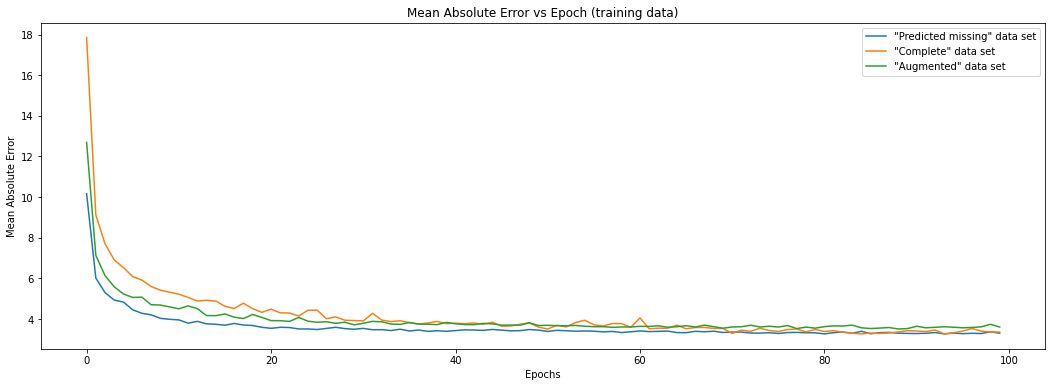

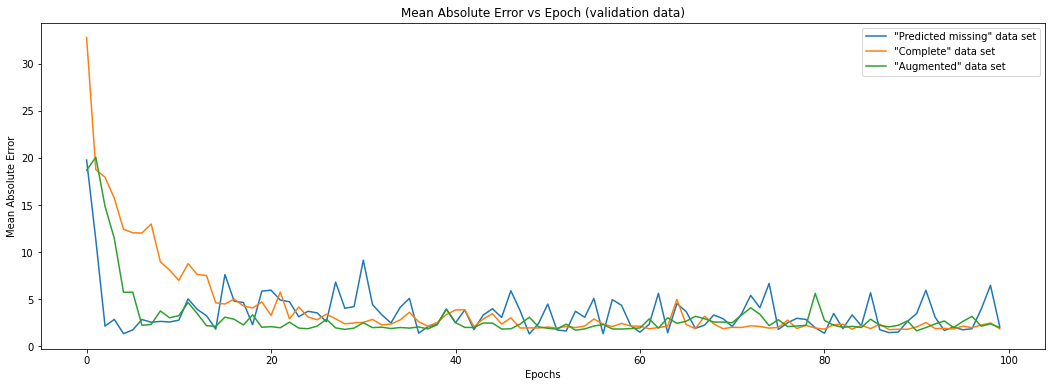

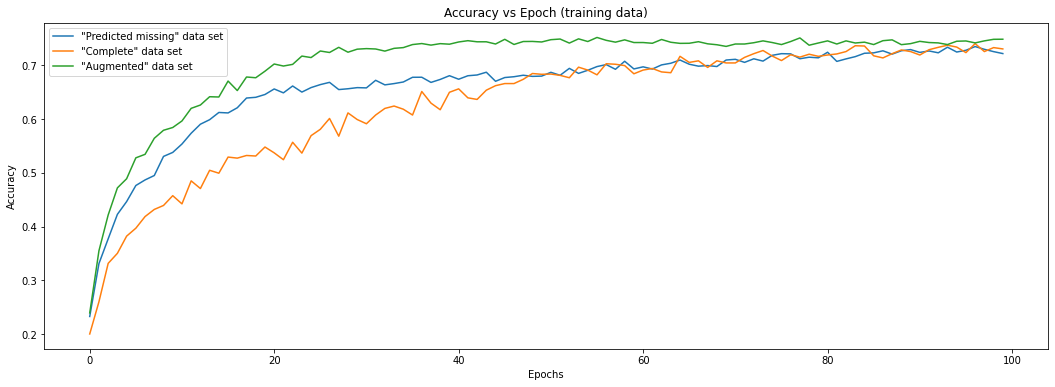

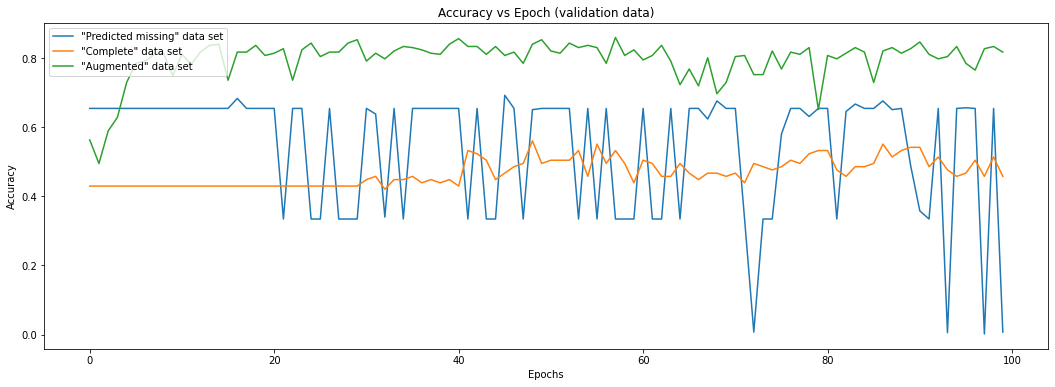

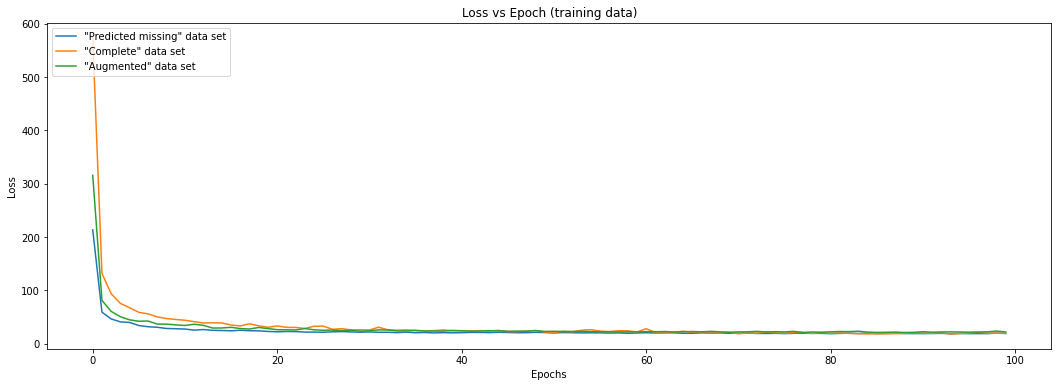

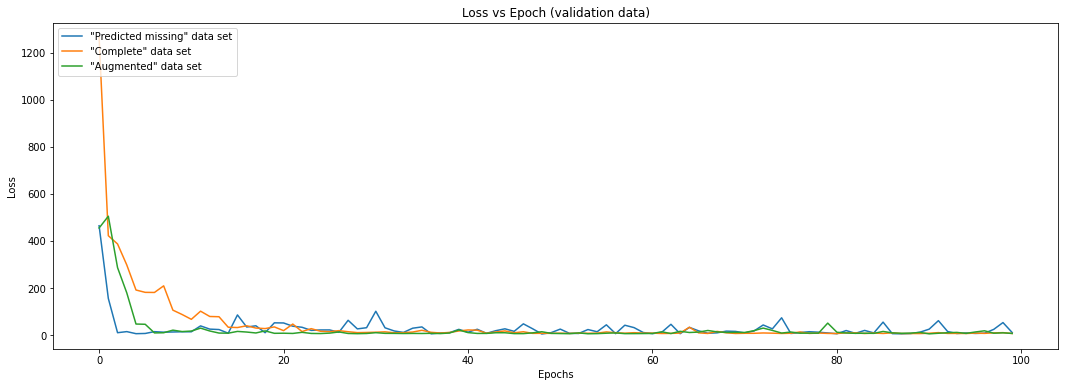

In [ ]:
# plot to show training MAE over time
plt.plot(pred_keypoints_history.history['mae'])
plt.plot(complete_history.history['mae'])
plt.plot(augmented_history.history['mae'])
plt.title('Mean Absolute Error vs Epoch (training data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper right')
plt.show()

# plot to show validation MAE over time
plt.plot(pred_keypoints_history.history['val_mae'])
plt.plot(complete_history.history['val_mae'])
plt.plot(augmented_history.history['val_mae'])
plt.title('Mean Absolute Error vs Epoch (validation data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper right')
plt.show()

# plot to show training accuracy over time
plt.plot(pred_keypoints_history.history['acc'])
plt.plot(complete_history.history['acc'])
plt.plot(augmented_history.history['acc'])
plt.title('Accuracy vs Epoch (training data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show validation accuracy over time
plt.plot(pred_keypoints_history.history['val_acc'])
plt.plot(complete_history.history['val_acc'])
plt.plot(augmented_history.history['val_acc'])
plt.title('Accuracy vs Epoch (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show training loss over time
plt.plot(pred_keypoints_history.history['loss'])
plt.plot(complete_history.history['loss'])
plt.plot(augmented_history.history['loss'])
plt.title('Loss vs Epoch (training data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

# plot to show validation loss over time
plt.plot(pred_keypoints_history.history['val_loss'])
plt.plot(complete_history.history['val_loss'])
plt.plot(augmented_history.history['val_loss'])
plt.title('Loss vs Epoch (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['"Predicted missing" data set',
            '"Complete" data set',
            '"Augmented" data set'], loc='upper left')
plt.show()

It would appear that our model built with predicted missing data is unstable, based on the validation accuracy. Let's fit one last time, with early stopping to attempt to stop the model at a high-accuracy epoch.



In [ ]:
# define ES
es = EarlyStopping(monitor='val_acc', patience=75)
# predict again
pred_keypoints_history = pred_keypoints_model.fit(pred_keypoints_X_train,
                    pred_keypoints_y_train,
                    epochs = 75,
                    batch_size = 128,
                    validation_split=0.05,
                    callbacks=[es])

Epoch 1/75
82/82 [==============================] - 12s 147ms/step - loss: 19.8747 - mae: 3.3616 - acc: 0.7086 - val_loss: 90.7014 - val_mae: 7.5290 - val_acc: 0.0072
Epoch 2/75
82/82 [==============================] - 12s 146ms/step - loss: 19.3121 - mae: 3.3027 - acc: 0.7098 - val_loss: 6.6454 - val_mae: 1.7525 - val_acc: 0.6546
Epoch 3/75
82/82 [==============================] - 12s 146ms/step - loss: 19.4268 - mae: 3.3178 - acc: 0.7221 - val_loss: 9.6416 - val_mae: 2.3403 - val_acc: 0.4467
Epoch 4/75
82/82 [==============================] - 12s 147ms/step - loss: 18.9470 - mae: 3.2753 - acc: 0.7234 - val_loss: 63.9033 - val_mae: 6.1041 - val_acc: 0.3345
Epoch 5/75
82/82 [==============================] - 12s 147ms/step - loss: 18.8927 - mae: 3.2691 - acc: 0.7326 - val_loss: 14.0712 - val_mae: 2.7306 - val_acc: 0.3345
Epoch 6/75
82/82 [==============================] - 12s 146ms/step - loss: 18.8407 - mae: 3.2662 - acc: 0.7353 - val_loss: 5.4600 - val_mae: 1.5150 - val_acc: 0.6546
E

Now that we've stopped our fitting process at a more accurate point, we can continue. Below, we take a look at some predictions from our 3 functional models:

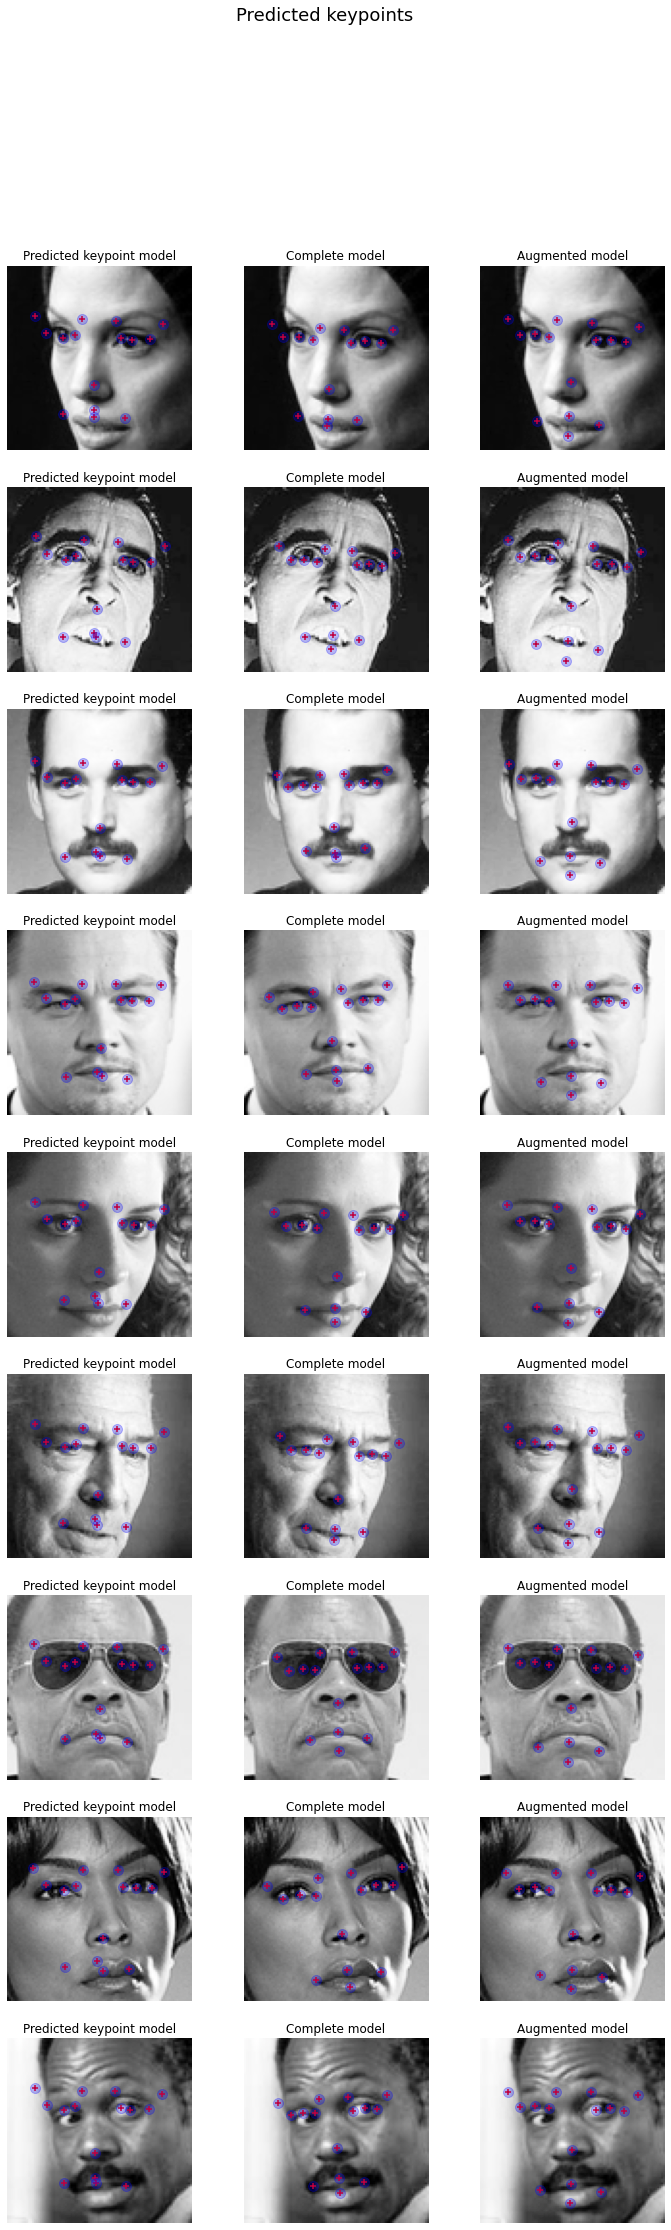

In [ ]:
# predict keypoints
pred_keypoints_pred = pred_keypoints_model.predict(incomplete_X_train)

# reshape keypoints
pred_keypoints_pred_xy = np.apply_along_axis(reshape_keypoints,
                                             1,
                                             pred_keypoints_pred)

# plot images with keypoints
fig, axs = plt.subplots(9, 3, figsize=(12, 36), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  if i in range(0, 27, 3):
    i_orig = i
    img = incomplete_X_train[i+60]
    keys = pred_keypoints_pred_xy[i+60]
    ax.title.set_text('Predicted keypoint model')
  elif i in range(1, 27, 3):
    keys = complete_pred_xy[i_orig+60]
    ax.title.set_text('Complete model')
  elif i in range(2, 27, 3):
    keys = augmented_pred_xy[i_orig+60]
    ax.title.set_text('Augmented model')
  ax.imshow(np.reshape(img*(-1), [96, 96]), cmap='Greys')
  ax.axis('off')
  ax.scatter(keys[:,0],
             keys[:,1],
             marker='+', c='red')
  ax.scatter(keys[:,0],
             keys[:,1],
             s=100, c='blue', alpha=0.25)
plt.suptitle('Predicted keypoints', size=18)
plt.show()

# Final Model Building Process

Overall, the predicted keypoint model does not appear to perform particularly well. Visually, it seems as though the complete model tends to have keypoints that match up better than any other model. 

It does appear as though regardless of the submission type, the predicted keypoints are quite rigid across predictions. We hypothesize that this may be caused by the fact that a large portion of faces have keypoints in very similar positions within the image. We'd like to explore further on if this "rigid" effect can be minimized by training a model on ONLY the data that has undergone transformations. We will progress as follows:

1. Transform each image in the "Complete" data set
2. Train intermediate model on this
3. Predict the missing keypoints from the "Incomplete" data set
4. Transform each of the predicted keypoint images
5. Train our final model on the combined "complete" and "predicted incomplete" data sets

Final model training data set:
- Transformed images with all existing keypoints provided
- Transformed images with some keypoints provided and missing keypoints predicted




In [ ]:
# define function to generate images and keypoints
def transform_data(X, y):
  xy = np.apply_along_axis(reshape_keypoints, 1, y)
  for i, keypoints in enumerate(y):
    success = False
    while not success:
      # generator for only this image
      seed = randint(1, 10000) 
      generator = zip(image_datagen.flow(x=np.expand_dims(X[i], axis=0), seed=seed),
                      landmark_datagen.flow_landmarks(np.expand_dims(xy[i], axis=0), seed=seed))
      # generate batches of images and keypoints
      for imgs, landmarks in generator:
        # iterate over keypoints in batch
        for ind, landmark in enumerate(landmarks):
          # skip where any keypoint is outside boundary
          if np.any(landmark[:, 2]==0):
            continue
          success = True
          if i == 0:
            XX = np.expand_dims(imgs[ind], axis=0)
            yy = unpack_keypoints(landmark).T
            break
          else:
            # append image
            XX = np.append(XX, np.expand_dims(imgs[ind], axis=0), axis=0)
            yy = np.append(yy, unpack_keypoints(landmark).T, axis=0)
            break
        break
  return XX, yy

# transform all samples
t_complete_X_train, t_complete_y_train = transform_data(complete_X_train,
                                                        complete_y_train)

In the code above, we transformed all of our samples to obtain the data for the complete data set. That was Part 1 from the above recipe. Now below, we will take a look at what this transformed data actually looks like.

This allows us to dramatically increase our training set amount, while allowing us to obtain new data.

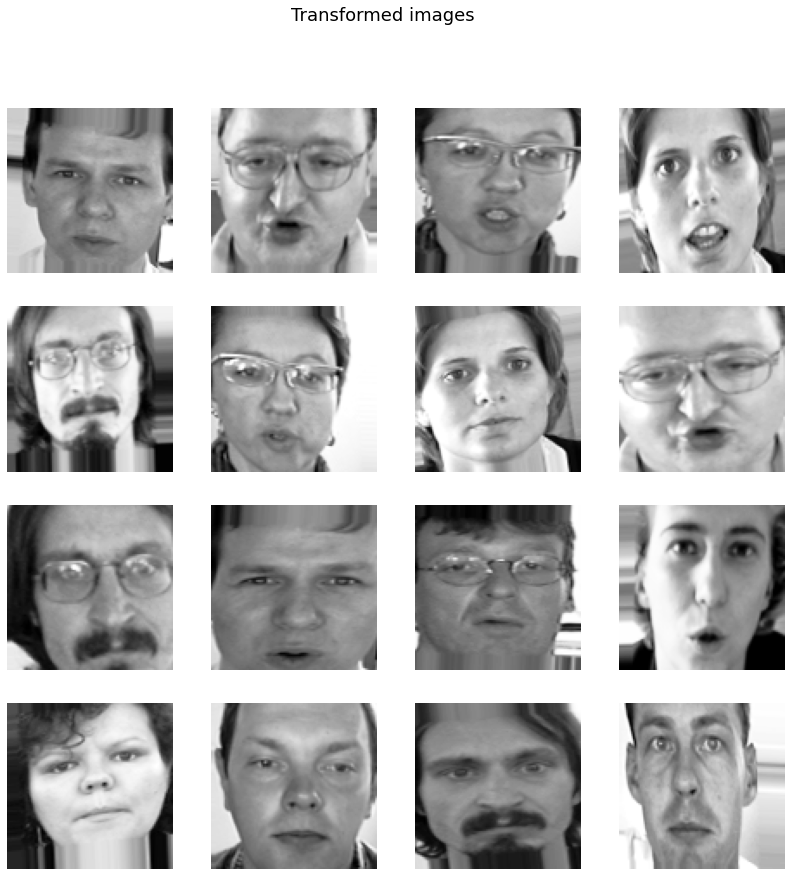

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(4, 4, figsize=(14, 14), sharex=True, sharey=True)
for ind, ax in enumerate(axs.flatten()):
  i = ind+1000
  ax.imshow(t_complete_X_train[i].reshape(96,96)*(-1), cmap='Greys')
  ax.axis('off')
plt.suptitle('Transformed images', size=18)
plt.show()

Next, we're going to train an intermediate model. This is part 2 of the above recipe. By doing this now, we are going to be able to predict the values for the data where all of the keypoints were not given. This will allow us to further expand our dataset.



In [ ]:
# copy model
t_complete_model = clone_model(model)

# compile model
t_complete_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae', 'acc'])

# predict again
t_complete_history = t_complete_model.fit(t_complete_X_train,
                    t_complete_y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_split=0.05,
                    callbacks=[es])

Epoch 1/100
16/16 [==============================] - 2s 152ms/step - loss: 588.7616 - mae: 18.0713 - acc: 0.2130 - val_loss: 1293.1215 - val_mae: 32.7137 - val_acc: 0.4393
Epoch 2/100
16/16 [==============================] - 2s 139ms/step - loss: 151.7398 - mae: 9.7685 - acc: 0.3035 - val_loss: 407.3791 - val_mae: 17.8344 - val_acc: 0.4393
Epoch 3/100
16/16 [==============================] - 2s 138ms/step - loss: 113.2780 - mae: 8.4652 - acc: 0.3148 - val_loss: 203.1165 - val_mae: 12.1051 - val_acc: 0.4393
Epoch 4/100
16/16 [==============================] - 2s 140ms/step - loss: 88.7333 - mae: 7.4716 - acc: 0.3665 - val_loss: 163.7591 - val_mae: 10.7643 - val_acc: 0.4860
Epoch 5/100
16/16 [==============================] - 2s 140ms/step - loss: 82.0273 - mae: 7.1758 - acc: 0.4019 - val_loss: 230.3559 - val_mae: 13.2058 - val_acc: 0.5607
Epoch 6/100
16/16 [==============================] - 2s 141ms/step - loss: 72.6434 - mae: 6.7314 - acc: 0.4265 - val_loss: 119.4245 - val_mae: 9.1926 

Ultimately, that intermediate model produced an MAE of 3.76, an accuracy of 0.77, a validation MAE of 2.17 and a validation accuracy of 0.68. This is a fairly accurate model that will be a good predictor for our missing keypoints.

Now let's fill in the missing keypoints, transform the images, append these transformations to our transformed complete data set, and train one final model. This is Part 3 of the above workflow.

In [ ]:
# predict missing points
t_complete_pred = t_complete_model.predict(incomplete_X_train)

# merge missing points
pred_incomplete_y_train = np.where(
    np.isnan(incomplete_y_train),
    t_complete_pred,
    incomplete_y_train
)

# transform
t_incomplete_X_train, t_incomplete_y_train = transform_data(
    incomplete_X_train, pred_incomplete_y_train)

# append to augmented data
final_X_train = np.append(t_complete_X_train, t_incomplete_X_train, axis=0)
final_y_train = np.append(t_complete_y_train, t_incomplete_y_train, axis=0)

In [ ]:
# copy model
final_model = clone_model(model)

# compile model
final_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae', 'acc'])

# predict again
es = EarlyStopping(monitor='val_loss', patience=75)
final_history = final_model.fit(final_X_train,
                    final_y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_split=0.05,
                    callbacks=[es])

Epoch 1/100
53/53 [==============================] - 8s 142ms/step - loss: 246.5790 - mae: 11.5254 - acc: 0.3928 - val_loss: 157.6653 - val_mae: 10.0104 - val_acc: 0.8895
Epoch 2/100
53/53 [==============================] - 7s 138ms/step - loss: 87.5855 - mae: 7.3166 - acc: 0.5660 - val_loss: 99.9224 - val_mae: 8.2618 - val_acc: 0.8895
Epoch 3/100
53/53 [==============================] - 7s 139ms/step - loss: 67.9259 - mae: 6.4205 - acc: 0.6353 - val_loss: 68.5303 - val_mae: 6.9109 - val_acc: 0.8952
Epoch 4/100
53/53 [==============================] - 7s 139ms/step - loss: 60.2614 - mae: 5.9945 - acc: 0.6643 - val_loss: 19.6644 - val_mae: 3.3522 - val_acc: 0.8924
Epoch 5/100
53/53 [==============================] - 7s 140ms/step - loss: 51.6356 - mae: 5.5357 - acc: 0.7006 - val_loss: 19.5191 - val_mae: 3.3577 - val_acc: 0.8612
Epoch 6/100
53/53 [==============================] - 7s 140ms/step - loss: 47.4077 - mae: 5.2943 - acc: 0.7095 - val_loss: 40.6413 - val_mae: 5.1376 - val_acc: 0

Now, we have a model that combines the given "complete" data, the augmented predictions from the "complete" data and our new "incomplete" data with the incompleteness filled in by predictions from that intermediate model. This new model produced an MAE of 3.53, an accuracy of 0.85, a validation MAE of 2.89 and a validation accuracy of 0.92. This is a much more accurate model that will be a great predictor for our testing data.

Next, we can explore this accuracy through plotting these MAE, accuracy and loss values.

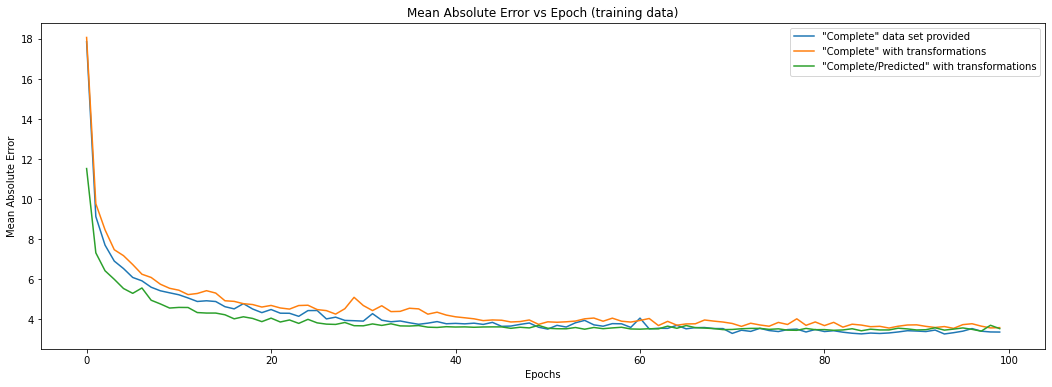

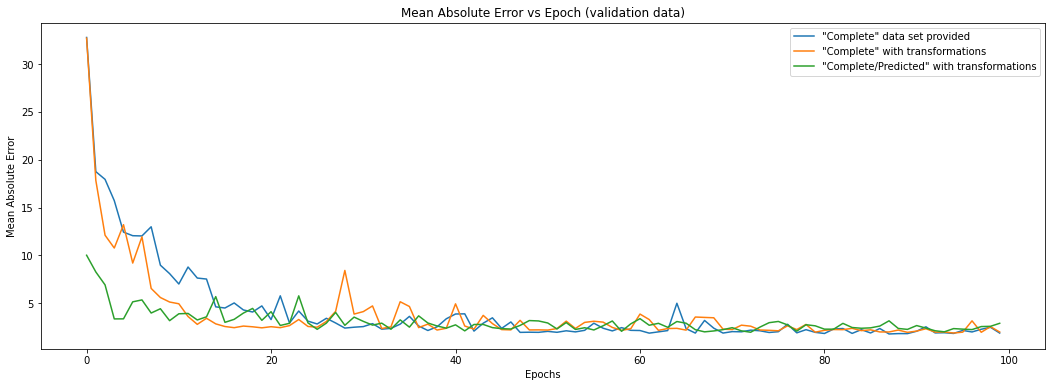

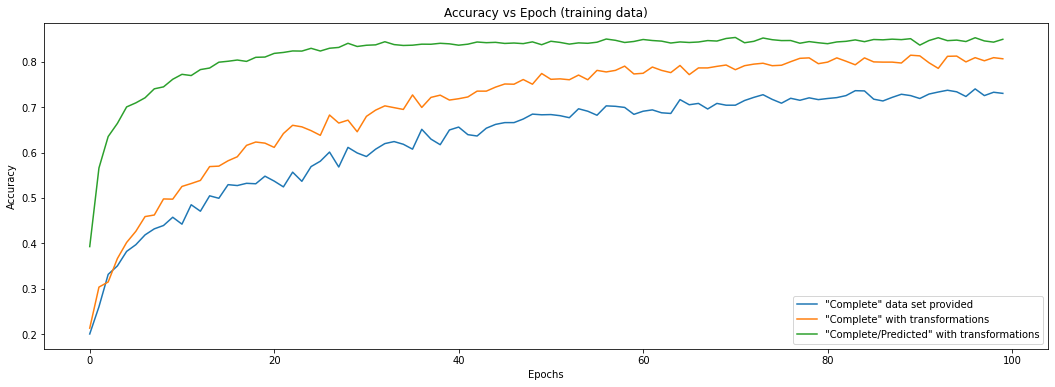

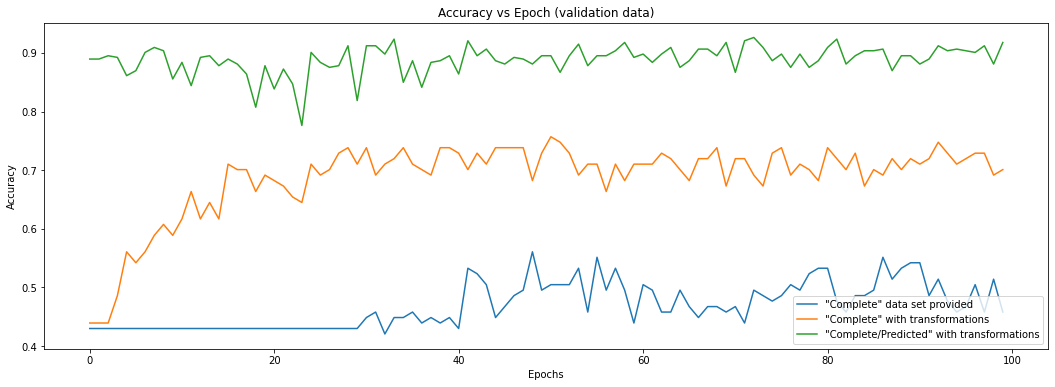

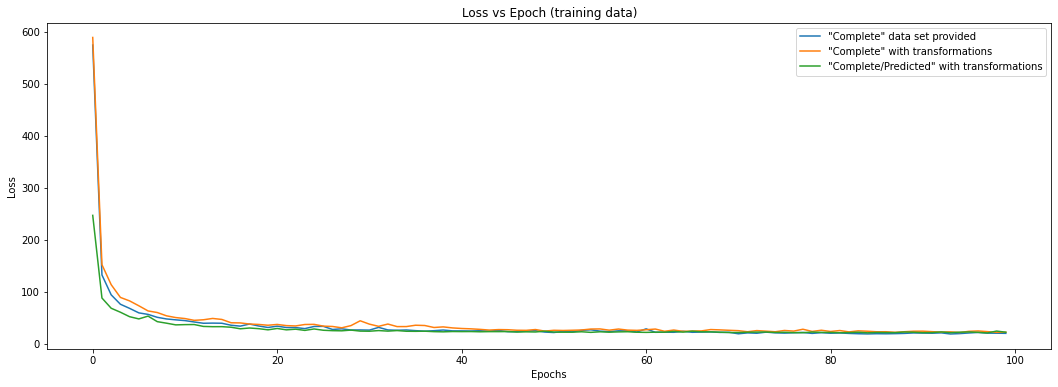

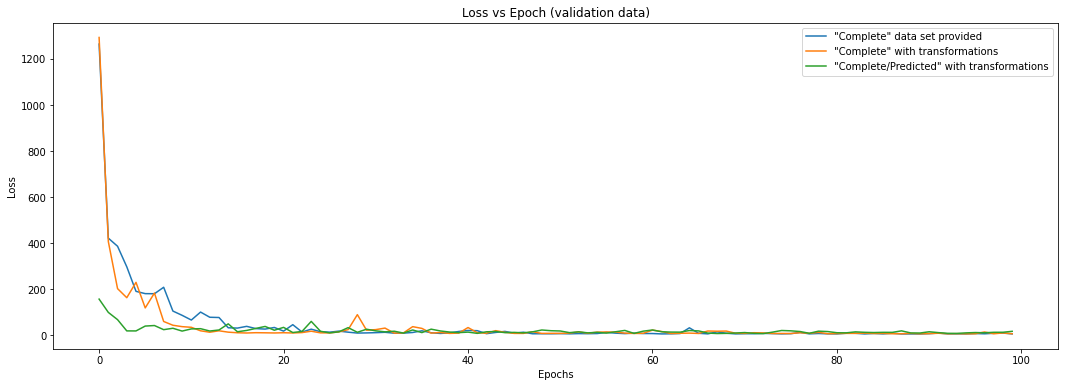

In [ ]:
# plot to show training MAE over time
plt.plot(complete_history.history['mae'])
plt.plot(t_complete_history.history['mae'])
plt.plot(final_history.history['mae'])
plt.title('Mean Absolute Error vs Epoch (training data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='upper right')
plt.show()

# plot to show validation MAE over time
plt.plot(complete_history.history['val_mae'])
plt.plot(t_complete_history.history['val_mae'])
plt.plot(final_history.history['val_mae'])
plt.title('Mean Absolute Error vs Epoch (validation data)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='upper right')
plt.show()

# plot to show training accuracy over time
plt.plot(complete_history.history['acc'])
plt.plot(t_complete_history.history['acc'])
plt.plot(final_history.history['acc'])
plt.title('Accuracy vs Epoch (training data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='lower right')
plt.show()

# plot to show validation accuracy over time
plt.plot(complete_history.history['val_acc'])
plt.plot(t_complete_history.history['val_acc'])
plt.plot(final_history.history['val_acc'])
plt.title('Accuracy vs Epoch (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='lower right')
plt.show()

# plot to show training loss over time
plt.plot(complete_history.history['loss'])
plt.plot(t_complete_history.history['loss'])
plt.plot(final_history.history['loss'])
plt.title('Loss vs Epoch (training data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='upper right')
plt.show()

# plot to show validation loss over time
plt.plot(complete_history.history['val_loss'])
plt.plot(t_complete_history.history['val_loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Loss vs Epoch (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['"Complete" data set provided',
            '"Complete" with transformations',
            '"Complete/Predicted" with transformations'], loc='upper right')
plt.show()

The complete/predicted with transformations model performs the best on the validation set of data, though appears to cap out around 70% accuracy against the training set. Both of the transformed models appear to perform better than the untransformed model in every regard.

We can now take a look at how this model works when predicting other data. Let's look at some predictions:

In [ ]:
# predict
final_pred = final_model.predict(incomplete_X_train)

In [ ]:
# reshape keypoints
t_complete_pred_xy = np.apply_along_axis(reshape_keypoints, 1, t_complete_pred)
final_pred_xy = np.apply_along_axis(reshape_keypoints, 1, final_pred)

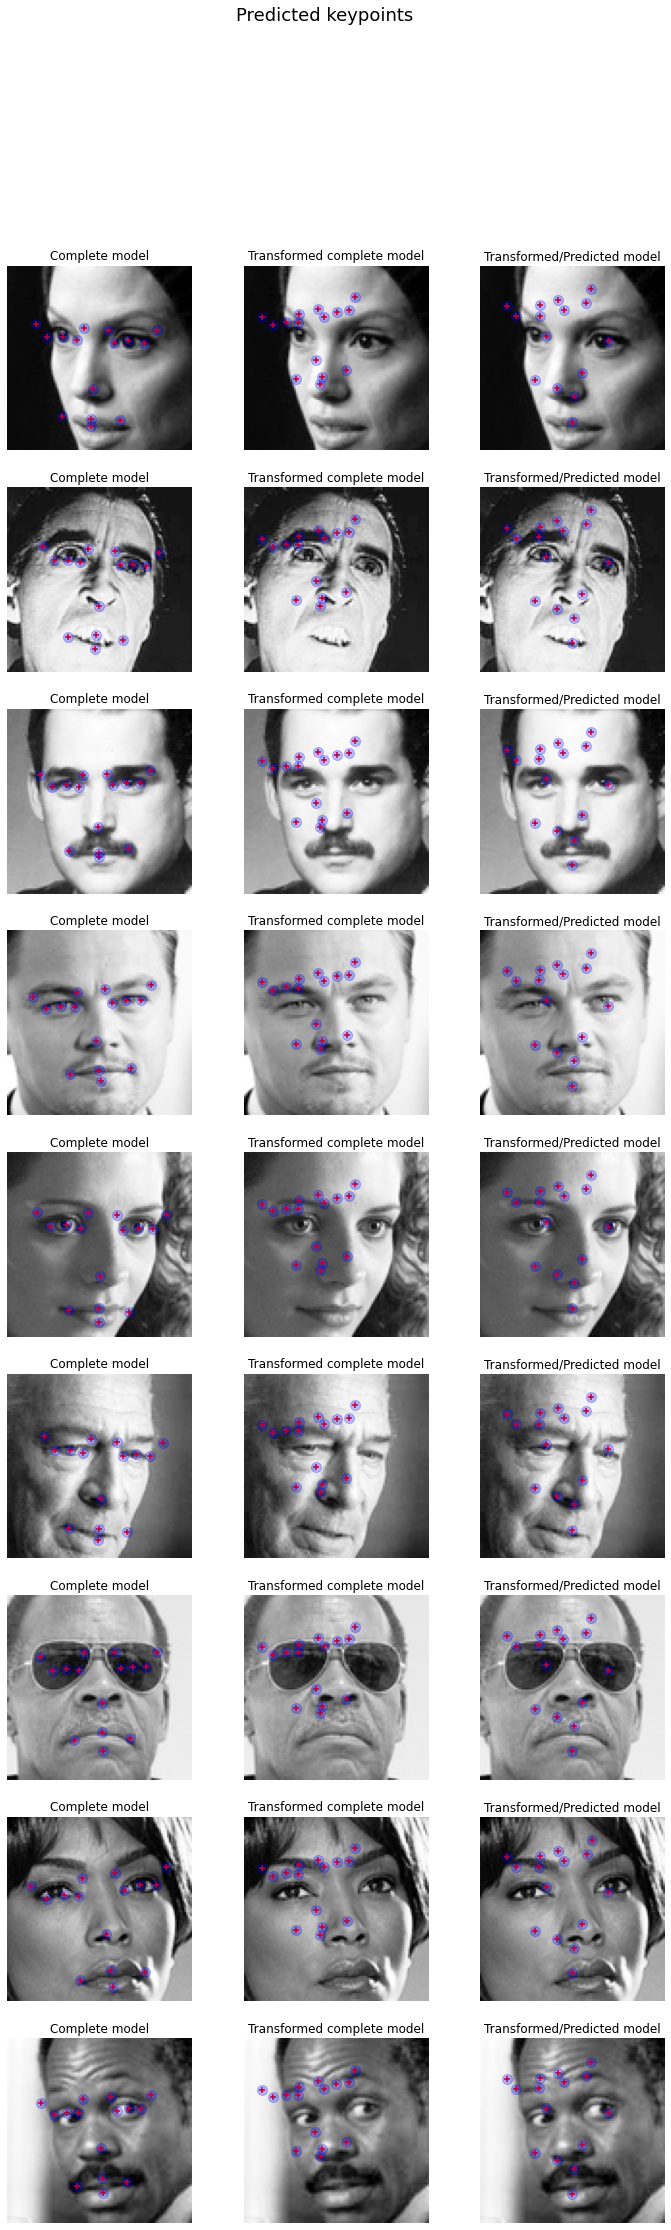

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(9, 3, figsize=(12, 36), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  if i in range(0, 27, 3):
    i_orig = i
    img = incomplete_X_train[i+60]
    keys = complete_pred_xy[i+60]
    ax.title.set_text('Complete model')
  elif i in range(1, 27, 3):
    img = incomplete_X_train[i_orig+60]
    keys = t_complete_pred_xy[i_orig+60]
    ax.title.set_text('Transformed complete model')
  elif i in range(2, 27, 3):
    keys = final_pred_xy[i_orig+60]
    ax.title.set_text('Transformed/Predicted model')
  ax.imshow(np.reshape(img*(-1), [96, 96]), cmap='Greys')
  ax.axis('off')
  ax.scatter(keys[:,0],
             keys[:,1],
             marker='+', c='red')
  ax.scatter(keys[:,0],
             keys[:,1],
             s=100, c='blue', alpha=0.25)
plt.suptitle('Predicted keypoints', size=18)
plt.show()

After all of the experiments, transformations, and augmenting of data the model trained on simply the subset of data that contained full set of 15 keypoints appears to visually perform the best. This appears to move best with the data, however, let's take a closer look and confirm our suspicions.

# Final Test and Submission

Based on our suspicions, from the last two pieces of information, we can see that our lowest MAE value occurred from the complete model, with all 15 existing keypoints. Despite all of the transformations and different features we implemented, we found that this simpler solution was more elegant and worked at a more accurate rate for our purposes.

The transformed model, with the transformations of the completed data, also worked well. Our augmented model, predicted keypoints model and transformed/predicted model also preformed well and all had MAEs under 3 and accuracies above 0.70.

In [ ]:
print("Base model (including nulls)")
b = base_model.evaluate(X_train, y_train)
print("Complete model (only images with all 15 existing keypoints)")
c = complete_model.evaluate(complete_X_train, complete_y_train)
print("Augmented model (Complete + transforms of complete)")
a = augmented_model.evaluate(augmented_X_train, augmented_y_train)
print("Predicted Keypoints model (Complete + transforms of complete + incomplete with predicted keypoints)")
p = pred_keypoints_model.evaluate(pred_keypoints_X_train, pred_keypoints_y_train)
print("Transformed model (Transforms of complete ONLY)")
t = t_complete_model.evaluate(t_complete_X_train, t_complete_y_train)
print("Transformed/Predicted model (Transforms of complete and transforms of predicted incomplete)")
f = final_model.evaluate(final_X_train, final_y_train)

Base model (including nulls)
221/221 [==============================] - 3s 14ms/step - loss: nan - mae: nan - acc: 0.0016
Complete model (only images with all 15 existing keypoints)
67/67 [==============================] - 1s 16ms/step - loss: 3.9798 - mae: 1.4815 - acc: 0.7299
Augmented model (Complete + transforms of complete)
192/192 [==============================] - 3s 14ms/step - loss: 8.4334 - mae: 2.1842 - acc: 0.7801
Predicted Keypoints model (Complete + transforms of complete + incomplete with predicted keypoints)
346/346 [==============================] - 5s 14ms/step - loss: 7.9035 - mae: 2.0210 - acc: 0.7207
Transformed model (Transforms of complete ONLY)
67/67 [==============================] - 1s 14ms/step - loss: 4.5536 - mae: 1.6097 - acc: 0.8416
Transformed/Predicted model (Transforms of complete and transforms of predicted incomplete)
221/221 [==============================] - 3s 14ms/step - loss: 11.6607 - mae: 2.5980 - acc: 0.8706


With this information in mind, let's begin the process of making predictions on the test data.

We'll first have to prepare the test data, by transforming the images and converting them in the same way we did for training. 

In [ ]:
# transform images
def process_test_data(data):
    images = []
    for idx, sample in data.iterrows():
      # extract and reshape image
      image = np.reshape(np.array(sample['Image'].split(' '),
                                  dtype=int),
                         (96,96,1))
      images.append(image)

    # normalize grayscale images and convert to array
    images = np.array(images)/255.
    return images

#preparing test data
X_test = process_test_data(test_data)

We'll then predict on the testing data using the complete model.

In [ ]:
# predict
test_pred = complete_model.predict(X_test)

# reshape keypoints
test_pred_xy = np.apply_along_axis(reshape_keypoints, 1, test_pred)

Next, let's visualize these test images with predicted keypoints.

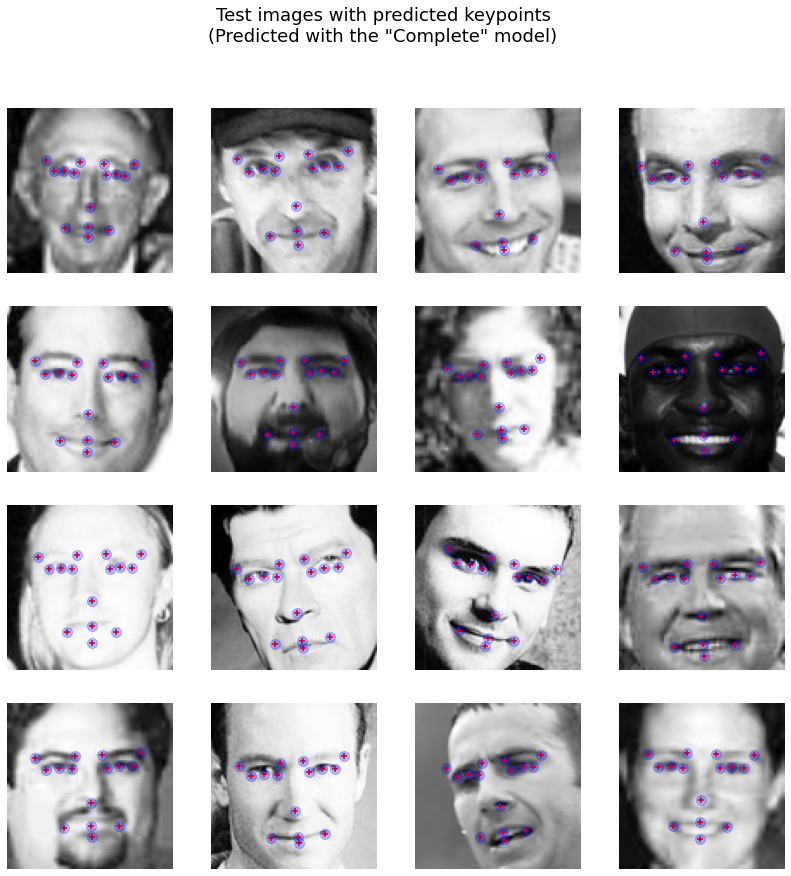

In [ ]:
# plot images with keypoints
fig, axs = plt.subplots(4, 4, figsize=(14, 14), sharex=True, sharey=True)
for ind, ax in enumerate(axs.flatten()):
  i = ind+1000
  ax.imshow(X_test[i].reshape(96,96)*(-1), cmap='Greys')
  ax.scatter(test_pred_xy[i,:,0],
             test_pred_xy[i,:,1], marker='+', c='red')
  ax.scatter(test_pred_xy[i,:,0],
             test_pred_xy[i,:,1], s=100, c='blue', alpha=0.25)
  ax.axis('off')
plt.suptitle('Test images with predicted keypoints\n(Predicted with the "Complete" model)', size=18)
plt.show()

So these images generally look good! Below is the code used to output the final model predictions for submission to Kaggle. Our submission was good enough for a 3.1 MAE in the Kaggle competition. This would've been good enough for 65th place in the event, if we had competed.

In [ ]:
# Take test predictions data and convert it into Kaggle's desired format.
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(test_pred)
rowid = lookid_data['RowId']
rowid=list(rowid)
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

# Obtain desired rows and predicted locations
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_key_detection_submission_finalth_attempt.csv',index = False)

# save models to load later if necessary
complete_model.save('complete_model')
final_model.save('final_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: complete_model/assets
INFO:tensorflow:Assets written to: final_model/assets


# Conclusion

Ultimately, given that this was our first foray into facial recognition, this project was successful for us. We were able to detect the 15 facial keypoints from static imagesWith a fairly good level of accuracy. Using the data provided by Kaggle allowed us to make relevant predictions and obtain reasonable results. As a result of our efforts, this project could be expanded to have many modern applications in the facial recognition space. 

There are certainly some growth areas as well. If we were to continue to work on this, we would certainly want to get a better sense for why our augmented and transformed data did not yield better results than simply using the raw images. Furthermore, we may even want to try to develop features from these images as a result. We would also want to explore the concept of facial geometry and potentially could develop some sort of clustering algorithm to classify similar types of faces to make better predictions. We may also want to consider using other data sources to help bolster our training data.

Ultimately, the approach we took was one rooted in our machine learning knowledge and backed by the various forms of research, we did for this analysis. We are confident that the decisions we made lead to better outcomes, such as our decision not to use forward filling and focus on predictions instead. These decisions lead us to a result that we are happy with and a successful model. 